# LLM - *Model for Sentiment Evaluation 1*
## Data Preparation

In [ ]:
ticker =  "AAPL"

In [ ]:
# 1) Import and reload your utils module
import importlib
import utils
importlib.reload(utils)

# 2) Bring the explode_sentiment_data function into scope
from utils import explode_sentiment_data

# explode_sentiment_data should have a signature like:
#   explode_sentiment_data(
#       ticker: str,
#       folder: str = 'news',
#       sentiment_lower: float = 0.3,
#       sentiment_upper: float = 0.3,
#       min_relevance_score: float = 0.5
#   ) -> (pd.DataFrame, pd.DataFrame)

# 1) Cargar noticias
df_news_full, df_news_filtered = explode_sentiment_data(
    ticker,
    folder="news",
    sentiment_lower=-0.2,
    sentiment_upper=0.2,
    min_relevance_score=0.5
)

# 2) Añadir índice una sola vez al full
df_news_full = df_news_full.reset_index(drop=True)
df_news_full["idx"] = df_news_full.index + 1  # LLM espera idx desde 1

# 3) Aplicar el índice también al filtrado, pero desde el full
df_news_filtered = df_news_full[df_news_full.index.isin(df_news_filtered.index)].copy()

# 4) Verificar
print("News Full:", df_news_full.shape)
print("News Filtered:", df_news_filtered.shape)

# 5) Ver algunos ejemplos
display(df_news_full.head(2))
display(df_news_filtered.head(2))


## Prompt

In [ ]:
import os
import math
import pandas as pd
import json
import openai
import time

# --- Configuration ---
openai.api_key = os.getenv("OPENAI_API_KEY")

base_output_path = f"data/llm/{ticker}"
os.makedirs(base_output_path, exist_ok=True)
output_path = f"{base_output_path}/df___{ticker}___llm.csv"

BATCH_SIZE = 25
PROCESS_ALL = True  # Set to True to process all rows

# --- Input Data ---
df_out = df_news_filtered.copy()

# ✅ Only add idx if not present
if "idx" not in df_out.columns:
    df_out = df_out.reset_index(drop=True)
    df_out["idx"] = df_out.index + 1

# --- Create CSV if missing ---
if not os.path.exists(output_path):
    df_init = df_out[["idx", "day_date", "week_date"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Results file initialized.")
else:
    print("📁 Existing file detected. Continuing…")

# --- System prompt ---
SYSTEM_PROMPT = """
You are a financial analyst LLM tasked with evaluating financial news items for their potential impact on a company's stock.

Each article includes:
- Title (headline)
- Summary (short description)
- Date of publication

Your job is to assign the following 3 scores per article:

---

📊 OUTPUT METRICS:

1. **ticker_sentiment_score**  
   - Measures the overall tone of the article toward the company.  
   - Range: −1.000 (extremely negative) to +1.000 (extremely positive)  
   - Use fine granularity (e.g., 0.742, −0.381) and round to **3 decimals**.

2. **ticker_relevance_score**  
   - Measures how directly the article relates to the company's stock, business, or fundamentals.  
   - Range: 0.000 (not related) to 1.000 (directly core)  
   - Examples:  
     - General tech sector piece: 0.200  
     - Apple Q2 earnings: 0.950  
     - Apple mentioned in passing: 0.100

3. **ticker_price_impact**  
   - Predict the expected **short-term stock price movement**.  
   - Range: −1.000 (strong negative reaction expected) to +1.000 (strong positive)  
   - Consider market context, surprise factor, sentiment, and likely investor reaction.

---

⚠️ GUIDELINES:

- Use both **title and summary** to determine scores.
- Be conservative with extreme scores: avoid 1.000 or −1.000 unless clearly justified.
- If the news is vague, generic, or expected, return scores close to 0.000 (e.g., 0.015, −0.023).
- Tone does not always imply price impact (e.g., positive but already priced in).

---

### Example 1: Positive Impact

- Title: *Apple beats earnings expectations in Q3*  
- Summary: *Revenue reached $91.3B, driven by iPhone sales, surpassing analyst forecasts.*

```json
{
  "results": [
    {
      "idx": 1,
      "ticker_sentiment_score": 0.850,
      "ticker_relevance_score": 0.980,
      "ticker_price_impact": 0.720
    }
  ]
}

### Example 2: Neutral / Generic
- Date: 2023-11-02
- Title: Apple to hold annual developer conference on June 5
- Summary: Apple announced it will host its Worldwide Developers Conference (WWDC) virtually from June 5–9.

```json
{
  "results": [
    {
      "idx": 2,
      "ticker_sentiment_score": 0.025,
      "ticker_relevance_score": 0.200,
      "ticker_price_impact": 0.015
    }
  ]
}

### Example 3: Negative (Bearish)
- Date: 2023-11-10
- Title: Apple faces $2B EU fine over antitrust violations
- Summary: The European Commission has fined Apple $2 billion for restricting competition in its App Store practices across the EU.

```json
{
  "results": [
    {
      "idx": 3,
      "ticker_sentiment_score": -0.820,
      "ticker_relevance_score": 0.950,
      "ticker_price_impact": -0.700
    }
  ]
}
"""

# --- Function to process each batch ---
def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        date = str(row["time_published"])
        title = row["title"].strip().replace("\n", " ")
        summary = row["summary"].strip().replace("\n", " ")[:180] + "…"
        lines.append(f"{row['idx']}|Date: {date} | Title: {title} | Summary: {summary}")

    user_content = "Evaluate the following news items:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_content}
            ],
            functions=[{
                "name": "evaluate_news",
                "description": "Evaluates news headlines and summaries",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "results": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "idx": {"type": "integer"},
                                    "ticker_sentiment_score": {"type": "number"},
                                    "ticker_relevance_score": {"type": "number"},
                                    "ticker_price_impact": {"type": "number"},
                                },
                                "required": [
                                    "idx", "ticker_sentiment_score",
                                    "ticker_relevance_score", "ticker_price_impact"
                                ]
                            }
                        }
                    },
                    "required": ["results"]
                }
            }],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=1000
        )
        msg = response.choices[0].message
        if msg.get("function_call"):
            args = msg.function_call.arguments
            return json.loads(args)["results"]
        else:
            print("⚠️ No function_call in response:", msg)
            return []
    except Exception as e:
        print("❌ OpenAI error:", e)
        return []

# --- Round scores to 0.05 precision ---
def round_to_0_05(x):
    return round(x * 20) / 20 if pd.notnull(x) else None

# --- Load previous results ---
df_results = pd.read_csv(output_path)
processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Completed: {len(processed_idxs)} / {len(df_out)}")

# --- Determine how many batches to run ---
total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1

# --- Main loop ---
for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Processing batch {k+1}/{total_batches} — rows {start} to {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned.")

        df_batch = pd.DataFrame(batch_results)
        for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact"]:
            df_batch[col] = df_batch[col].apply(round_to_0_05)

        df_results = df_results.set_index("idx")
        df_batch = df_batch.set_index("idx")
        df_results.update(df_batch)
        df_results = df_results.reset_index()
        df_results.to_csv(output_path, index=False)

        print(f"✅ Batch {k+1} saved.")
        time.sleep(3)

    except Exception as e:
        print(f"⚠️ Error in batch {k+1}: {e}")


# AMZN - *Examples*

### Example 1: Positive (Bullish)
- Title: Amazon Announces Prime Day Expansion to 25 Countries
- Summary: Amazon will host its annual Prime Day sale across 25 markets this year, up from 17 last year, aiming to boost international revenue.

```json
{
  "results": [
    {
      "idx": 4,
      "ticker_sentiment_score": 0.810,
      "ticker_relevance_score": 0.930,
      "ticker_price_impact": 0.650
    }
  ]
}
```
### Example 2: Neutral / Mixed
- Title: Amazon CEO Comments on Supply Chain Challenges
- Summary: Andy Jassy noted ongoing logistics issues but said AWS growth remains strong, balancing risks across divisions.

```json
{
  "results": [
    {
      "idx": 5,
      "ticker_sentiment_score": 0.045,
      "ticker_relevance_score": 0.680,
      "ticker_price_impact": 0.020
    }
  ]
}
```
### Example 3: Negative (Bearish)
- Title: EU Regulators Open Antitrust Probe into Amazon Marketplace
- Summary: The European Commission is investigating potential anti-competitive practices in Amazon’s third-party seller platform.

```json
{
  "results": [
    {
      "idx": 6,
      "ticker_sentiment_score": -0.755,
      "ticker_relevance_score": 0.990,
      "ticker_price_impact": -0.600
    }
  ]
}
```
---
# META - *Examples*
### Example 1: Positive (Bullish)  
  - Title: Meta Reports Record Q1 Ad Revenue, Beats Estimates  
  - Summary: Meta posted $35.4B in advertising revenue for Q1 2025, exceeding consensus by 8%, driven by strong performance on Reels and AI-driven targeting.  

  ```json
  {
    "results": [
      {
        "idx": 10,
        "ticker_sentiment_score": 0.845,
        "ticker_relevance_score": 0.970,
        "ticker_price_impact": 0.700
      }
    ]
  }
  ```

### Example 2: Neutral / Mixed  
  - Title: Meta Joins New Virtual Reality Standards Consortium  
  - Summary: Meta announced participation in an industry group to develop VR interoperability standards, alongside other headset makers.  

  ```json
  {
    "results": [
      {
        "idx": 11,
        "ticker_sentiment_score": 0.100,
        "ticker_relevance_score": 0.550,
        "ticker_price_impact": 0.020
      }
    ]
  }
  ```

### Example 3: Negative (Bearish)  
  - Title: Meta Hit with $1.3B EU Privacy Fine Over Data Practices  
  - Summary: European regulators imposed a €1.2B penalty on Meta for alleged violations of GDPR in ad targeting, marking one of the largest tech fines this year.  

  ```json
  {
    "results": [
      {
        "idx": 12,
        "ticker_sentiment_score": -0.760,
        "ticker_relevance_score": 0.990,
        "ticker_price_impact": -0.650
      }
    ]
  }
  ```

---
# MSFT - *Examples*

### Example 1: Positive (Bullish)
- Title: Microsoft Secures $1 Billion Contract for Azure Government Cloud
- Summary: The U.S. Department of Defense selects Azure for secure cloud infrastructure, highlighting AWS and Google Cloud competition.

```json
{
  "results": [
    {
      "idx": 7,
      "ticker_sentiment_score": 0.830,
      "ticker_relevance_score": 0.950,
      "ticker_price_impact": 0.700
    }
  ]
}
```
### Example 2: Neutral / Industry-Wide
- Title: Microsoft Joins OpenAI in AI Safety Consortium
- Summary: MSFT partners with leading tech firms to develop guidelines and tools for safe AI deployment, without new funding commitments.

```json
{
  "results": [
    {
      "idx": 8,
      "ticker_sentiment_score": 0.120,
      "ticker_relevance_score": 0.600,
      "ticker_price_impact": 0.050
    }
  ]
}
```
### Example 3: Negative (Bearish)
- Title: Windows 11 Adoption Slower Than Expected, Market Share Flat
- Summary: Industry data shows Windows 11 uptake plateauing at 30%, raising questions about upgrade cycles and OEM partnerships.

```json
{
  "results": [
    {
      "idx": 9,
      "ticker_sentiment_score": -0.430,
      "ticker_relevance_score": 0.850,
      "ticker_price_impact": -0.320
    }
  ]
}

```
---

# NVDA - *Examples*

### Example 1: Positive (Bullish)  
- Title: NVIDIA Unveils Next-Gen AI GPU with 3× Performance Boost  
- Summary: NVIDIA’s new H200 GPU delivers triple the inference speed of its predecessor, targeting hyperscale data centers and cloud AI services.  

```json
{
"results": [
    {
    "idx": 13,
    "ticker_sentiment_score": 0.900,
    "ticker_relevance_score": 0.980,
    "ticker_price_impact": 0.800
    }
]
}
```

### Example 2: Neutral / Industry-Wide  
- Title: NVIDIA to Host GTC Developer Conference Next Month  
- Summary: NVIDIA announced its annual GPU Technology Conference will be virtual and in-person events, focusing on AI research and developer tools.  

```json
{
"results": [
    {
    "idx": 14,
    "ticker_sentiment_score": 0.020,
    "ticker_relevance_score": 0.400,
    "ticker_price_impact": 0.010
    }
]
}
```

### Example 3: Negative (Bearish)  
- Title: NVIDIA Warns Supply Chain Constraints May Hurt Q2 Shipments  
- Summary: CEO Jensen Huang cautioned that component shortages and freight delays could reduce Q2 GPU shipments by up to 5%.  

```json
{
"results": [
    {
    "idx": 15,
    "ticker_sentiment_score": -0.450,
    "ticker_relevance_score": 0.900,
    "ticker_price_impact": -0.300
    }
]
}
```
---

# TSLA - *Examples*
### Example 1: Positive Impact
- Title: Tesla Beats Expectations with Record Q4 Deliveries  
- Summary: Tesla delivered 484,000 vehicles in Q4 2023, beating Wall Street estimates by over 20,000 units.

```json
{
  "results": [
    {
      "idx": 1,
      "ticker_sentiment_score": 0.875,
      "ticker_relevance_score": 0.970,
      "ticker_price_impact": 0.720
    }
  ]
}
```
### Example 2: Neutral / Generic
- Title: Tesla to Present at Upcoming Auto Innovation Forum
- Summary: Tesla announced its participation in an EV-focused conference next month, joining other major manufacturers.

```json
{
  "results": [
    {
      "idx": 2,
      "ticker_sentiment_score": 0.030,
      "ticker_relevance_score": 0.300,
      "ticker_price_impact": 0.015
    }
  ]
}
```
### Example 3: Negative (Bearish)
- Title: Tesla Recalls 362,000 Vehicles Over Full-Self Driving Flaws
- Summary: NHTSA says Tesla's self-driving beta may cause unsafe maneuvers. Recall affects key U.S. markets.

```json
{
  "results": [
    {
      "idx": 3,
      "ticker_sentiment_score": -0.820,
      "ticker_relevance_score": 0.980,
      "ticker_price_impact": -0.700
    }
  ]
  }
```

# LLM - *Model for Sentiment Evaluation 2*

## Data Preparation
Here we add technical so we need to do some data prepartion

In [18]:
import importlib
import utils
from utils import load_prices

df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks')

df_prices_daily = df_prices_daily.reset_index()

df_prices_daily.columns = [
    "day_date",         # previously 'date'
    "open",             # "1. open"
    "high",             # "2. high"
    "low",              # "3. low"
    "close",            # "4. close"
    "adjusted_close",   # already renamed
    "volume",           # "6. volume"
    "dividend_amount",  # "7. dividend amount"
    "split_coefficient" # "8. split coefficient"
]
df_prices_daily.head()


day_date   open     high    low  close  adjusted_close    volume  \
0 2010-06-29  19.00  25.0000  17.54  23.89        1.592667  18766300   
1 2010-06-30  25.79  30.4192  23.30  23.83        1.588667  17187100   
2 2010-07-01  25.00  25.9200  20.27  21.96        1.464000   8218800   
3 2010-07-02  23.00  23.1000  18.71  19.20        1.280000   5139800   
4 2010-07-06  20.00  20.0000  15.83  16.11        1.074000   6866900   

   dividend_amount  split_coefficient  
0              0.0                1.0  
1              0.0                1.0  
2              0.0                1.0  
3              0.0                1.0  
4              0.0                1.0

In [19]:
df_news_filtered["day_date"] = pd.to_datetime(df_news_filtered["day_date"])

df_merged = pd.merge(df_news_filtered, df_prices_daily, on="day_date", how="left")

df_merged.columns

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount',
       'split_coefficient'],
      dtype='object')

In [20]:
import os
import math
import pandas as pd
import json
import openai
import time

# --- Configuration ---
openai.api_key = os.getenv("OPENAI_API_KEY")

base_output_path = f"data/llm/{ticker}"
os.makedirs(base_output_path, exist_ok=True)
output_path = f"{base_output_path}/df___{ticker}___llm_tech.csv"

BATCH_SIZE = 25
PROCESS_ALL = True  # Set to True to process all rows

# --- Input Data ---
df_out = df_merged.copy()

# Agregar columna diaria de retorno si no existe
if "daily_return" not in df_out.columns:
    df_out = df_out.sort_values("day_date")
    df_out["daily_return"] = df_out["adjusted_close"].pct_change(fill_method=None)

# ✅ Only add idx if not present
if "idx" not in df_out.columns:
    df_out = df_out.reset_index(drop=True)
    df_out["idx"] = df_out.index + 1

# --- Create CSV if missing ---
if not os.path.exists(output_path):
    df_init = df_out[["idx", "day_date", "week_date"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Results file initialized.")
else:
    print("📁 Existing file detected. Continuing…")

# Prompt extendido incluyendo datos técnicos
SYSTEM_PROMPT = """
You are a financial news analyst tasked with evaluating the tone, relevance, and potential market impact of news articles related to a specific company (stock ticker).

For each news item, you are given:
- Date of publication
- Title
- Summary
- Market context for that day:
  - Open, High, Low, Close, Adjusted Close prices
  - Volume traded
  - Daily return (percentage change)

Your job is to assign the following 3 scores per article:

---

📊 OUTPUT METRICS:

1. **ticker_sentiment_score**  
   - Measures the overall tone of the article toward the company.  
   - Range: −1.000 (extremely negative) to +1.000 (extremely positive)  
   - Use fine granularity (e.g., 0.742, −0.381) and round to **3 decimals**.

2. **ticker_relevance_score**  
   - Measures how directly the article relates to the company's stock, business, or fundamentals.  
   - Range: 0.000 (not related) to 1.000 (directly core)  
   - Examples:  
     - General tech sector piece: 0.200  
     - Apple Q2 earnings: 0.950  
     - Apple mentioned in passing: 0.100

3. **ticker_price_impact**  
   - Predict the expected **short-term stock price movement**.  
   - Range: −1.000 (strong negative reaction expected) to +1.000 (strong positive)  
   - Consider market context, surprise factor, sentiment, and likely investor reaction.

---

⚠️ GUIDELINES:

- Use both **title and summary** to determine scores.
- Be conservative with extreme scores: avoid 1.000 or −1.000 unless clearly justified.
- If the news is vague, generic, or expected, return scores close to 0.000 (e.g., 0.015, −0.023).
- Tone does not always imply price impact (e.g., positive but already priced in).

---

### Example

Input:
Date: 2023-10-27  
Title: Apple reports record quarterly earnings, surpassing expectations  
Summary: Apple posted Q4 earnings of $1.46 per share on $89.5B in revenue, beating analyst estimates. Strong iPhone 15 sales contributed significantly to the results.  
Market: open=171.1, high=175.3, low=170.0, close=174.5, adjusted_close=174.5, volume=98000000, return=+2.7%

Expected Output:
{
  "results": [
    {
      "idx": 1,
      "ticker_sentiment_score": 0.850,
      "ticker_relevance_score": 0.980,
      "ticker_price_impact": 0.720
    }
  ]
}

---

Now continue evaluating the following news items. Return only the JSON.
"""

FUNCTION_DEF = {
    "name": "evaluate_news",
    "description": "Evaluates news headlines with technical market context",
    "parameters": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "idx": {"type": "integer"},
                        "ticker_sentiment_score": {"type": "number"},
                        "ticker_relevance_score": {"type": "number"},
                        "ticker_price_impact": {"type": "number"}
                    },
                    "required": [
                        "idx", "ticker_sentiment_score",
                        "ticker_relevance_score", "ticker_price_impact"
                    ]
                }
            }
        },
        "required": ["results"]
    }
}

def round_to_0_05(x):
    return round(x * 20) / 20 if pd.notnull(x) else None

def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        date = str(row["time_published"])
        title = row["title"].replace("\n", " ").strip()
        summary = row["summary"].replace("\n", " ").strip()[:200] + "…"
        market = (
            f"open={row['open']}, high={row['high']}, low={row['low']}, "
            f"close={row['close']}, adjusted_close={row['adjusted_close']}, "
            f"volume={row['volume']}, return={row['daily_return']:+.2%}"
        )
        lines.append(f"{row['idx']}|Date: {date} | Title: {title} | Summary: {summary} | Market: {market}")

    user_content = "Evaluate the following news items with their technical context:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_content}
            ],
            functions=[FUNCTION_DEF],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=1000
        )

        msg = response.choices[0].message
        if msg.get("function_call"):
            args = msg.function_call.arguments
            return json.loads(args)["results"]
        else:
            print("⚠️ No se devolvió function_call")
            print(msg)
            return []

    except Exception as e:
        print("❌ Error en la llamada a OpenAI:", e)
        return []

# Cargamos CSV parcial y detectamos qué filas faltan
df_results = pd.read_csv(output_path)
processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Total procesadas: {len(processed_idxs)} / {len(df_out)}")

# Ejecutar por lotes
total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1  # Solo el primer batch

for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Procesando batch {k+1}/{total_batches} — filas {start} a {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned")
        
        if batch_results and isinstance(batch_results, list) and "idx" in batch_results[0]:
            df_batch_results = pd.DataFrame(batch_results)

            for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact"]:
                df_batch_results[col] = df_batch_results[col].apply(round_to_0_05)

            if "idx" not in df_batch_results.columns:
                raise ValueError("❌ 'idx' missing in model response.")

            df_results = df_results.set_index("idx")
            df_batch_results = df_batch_results.set_index("idx")

            df_results.update(df_batch_results)
            df_results = df_results.reset_index()
            df_results.to_csv(output_path, index=False)

            print(f"✅ Batch {k+1} guardado correctamente.\n")
            print(df_batch_results.head())
            time.sleep(3)  # Pausa entre batches para evitar límite de OpenAI
        else:
            raise ValueError("❌ Batch response is empty or invalid.")

        print(f"✅ Batch {k+1} guardado correctamente.\n")
        print(df_batch_results.head())

    except Exception as e:
        print(f"⚠️ Error en batch {k+1}: {e}")

📁 Existing file detected. Continuing…
✅ Total procesadas: 5848 / 5848


# LLM - *Model for Sentiment Evaluation 3*

## Data Preparation & Enrichment with fundamental
Here we add technical and fundamental so we need to do some data prepartion

In [21]:
import requests
import pandas as pd
import os
from pathlib import Path 

# ────── CONFIG ───────────────────────────────────────────────
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")  # or replace with your key: "YOUR_KEY_HERE"
df_to_enrich = df_news_filtered.copy()  # <── SELECT YOUR INPUT SENTIMENT DF HERE
BASE_PATH = f"data/extract/stocks/{ticker}/prices"

# ────── STEP 1: DOWNLOAD FUNDAMENTALS ────────────────────────
urls = {
    "income": f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={API_KEY}",
    "balance": f"https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker}&apikey={API_KEY}",
    "cashflow": f"https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={API_KEY}"
}

financial_reports = {}

def fetch_quarterly_report(report_type):
    print(f"⏳ Downloading {report_type} report...")
    response = requests.get(urls[report_type])
    data = response.json()
    if "quarterlyReports" in data:
        df = pd.DataFrame(data["quarterlyReports"])
        financial_reports[report_type] = df
        print(f"✅ {report_type}: {df.shape[0]} quarters")
    else:
        print(f"❌ Failed to load {report_type} report:", data)

for report in ["income", "balance", "cashflow"]:
    fetch_quarterly_report(report)

# ────── STEP 2: CLEANING & RATIO CALCULATION ────────────────
def first_available_column(df, candidates):
    for col in candidates:
        if col in df.columns:
            return col
    raise ValueError(f"None of {candidates} found in DataFrame.")

def get_quarter_label(date):
    month = date.month
    quarter = (month - 1) // 3 + 1
    return f"{date.year}Q{quarter}"

def force_numeric(df):
    for c in df.columns:
        if c != "fiscalDateEnding":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df_income = financial_reports["income"].copy()
df_balance = financial_reports["balance"].copy()
df_cashflow = financial_reports["cashflow"].copy()

for df in [df_income, df_balance, df_cashflow]:
    df["fiscalDateEnding"] = pd.to_datetime(df["fiscalDateEnding"])
    df = force_numeric(df)

df_income = df_income[df_income["fiscalDateEnding"] >= "2022-01-01"]
df_balance = df_balance[df_balance["fiscalDateEnding"] >= "2022-01-01"]
df_cashflow = df_cashflow[df_cashflow["fiscalDateEnding"] >= "2022-01-01"]

df = df_balance.merge(df_income, on="fiscalDateEnding").merge(df_cashflow, on="fiscalDateEnding")

# Define fallback-safe columns
net_income_col = first_available_column(df, ["netIncome", "netIncomeFromContinuingOperations", "profitLoss"])
shares_col = first_available_column(df, ["commonStockSharesOutstanding"])

# Financial ratios
df["current_ratio"] = df["totalCurrentAssets"] / df["totalCurrentLiabilities"]
df["quick_ratio"] = (df["cashAndShortTermInvestments"] + df["currentNetReceivables"]) / df["totalCurrentLiabilities"]
df["debt_to_assets"] = df["totalLiabilities"] / df["totalAssets"]
df["debt_to_equity"] = df["totalLiabilities"] / df["totalShareholderEquity"]
df["gross_margin"] = df["grossProfit"] / df["totalRevenue"]
df["operating_margin"] = df["operatingIncome"] / df["totalRevenue"]
df["net_profit_margin"] = df[net_income_col] / df["totalRevenue"]
df["return_on_assets"] = df[net_income_col] / df["totalAssets"]
df["return_on_equity"] = df[net_income_col] / df["totalShareholderEquity"]
df["operating_cash_flow_ratio"] = df["operatingCashflow"] / df["totalCurrentLiabilities"]
df["free_cash_flow"] = df["operatingCashflow"] - df["capitalExpenditures"]
df["book_value_per_share"] = df["totalShareholderEquity"] / df[shares_col]
df["revenue_per_share"] = df["totalRevenue"] / df[shares_col]
df["eps"] = df[net_income_col] / df[shares_col]
df["quarter"] = df["fiscalDateEnding"].apply(get_quarter_label)

df_ratios = df[[
    "quarter", "eps", "book_value_per_share", "revenue_per_share",
    "current_ratio", "quick_ratio", "debt_to_assets", "debt_to_equity",
    "gross_margin", "operating_margin", "net_profit_margin",
    "return_on_assets", "return_on_equity", "operating_cash_flow_ratio", "free_cash_flow"
]]

# ────── STEP 3: LOAD WEEKLY PRICES ───────────────────────────
price_path = f"{BASE_PATH}/{ticker}_weekly_adjusted.csv"
df_price = pd.read_csv(price_path, usecols=["date", "5. adjusted close"])
df_price["date"] = pd.to_datetime(df_price["date"])
df_price = df_price[df_price["date"] >= "2022-01-01"].sort_values("date")
df_price = df_price.rename(columns={"5. adjusted close": "adjusted_close"})
df_price["quarter"] = df_price["date"].apply(get_quarter_label)

# ────── STEP 4: VALUATION RATIOS & ENRICHMENT ───────────────
df_final = df_price.merge(df_ratios, on="quarter", how="left")
df_final["PER"] = df_final["adjusted_close"] / df_final["eps"]
df_final["PB_ratio"] = df_final["adjusted_close"] / df_final["book_value_per_share"]
df_final["PS_ratio"] = df_final["adjusted_close"] / df_final["revenue_per_share"]
df_final["week"] = df_final["date"].dt.to_period("W").apply(lambda r: r.start_time)

# ────── STEP 5: MERGE WITH NEWS SENTIMENT DF ────────────────
df_to_enrich["time_published"] = pd.to_datetime(df_to_enrich["time_published"])
df_to_enrich["week"] = df_to_enrich["time_published"].dt.to_period("W").apply(lambda r: r.start_time)
df_merged = pd.merge(df_to_enrich, df_final.drop(columns=["date"]), on="week", how="left")

# ────── STEP 6: EXPORT AND PREVIEW ──────────────────────────
output_dir = Path(f"data/llm/{ticker}/fundamentals")
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / f"df___{ticker}___filtered___fund_enriched.csv"

try:
    df_merged.to_csv(output_file, index=False)
    print(f"✅ Final enriched DataFrame saved as {output_file}")
except PermissionError:
    print(f"❌ Permission denied writing to {output_file}. Comprueba permisos o cambia la ruta.")

⏳ Downloading income report...
✅ income: 70 quarters
⏳ Downloading balance report...
✅ balance: 70 quarters
⏳ Downloading cashflow report...
✅ cashflow: 70 quarters
✅ Final enriched DataFrame saved as data\llm\TSLA\fundamentals\df___TSLA___filtered___fund_enriched.csv


In [22]:
# --- Configuration ---
file_path = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker / "fundamentals" / f"df___{ticker}___filtered___fund_enriched.csv"

# --- Load full merged DataFrame ---
df_enriched = pd.read_csv(file_path)

df_enriched.columns


Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'week',
       'adjusted_close', 'quarter', 'eps', 'book_value_per_share',
       'revenue_per_share', 'current_ratio', 'quick_ratio', 'debt_to_assets',
       'debt_to_equity', 'gross_margin', 'operating_margin',
       'net_profit_margin', 'return_on_assets', 'return_on_equity',
       'operating_cash_flow_ratio', 'free_cash_flow', 'PER', 'PB_ratio',
       'PS_ratio'],
      dtype='object')

In [23]:
# 1) Import and reload your utils module
import importlib
import utils_llm
importlib.reload(utils_llm)

# 2) Bring the explode_sentiment_data function into scope
from utils_llm import process_llm_sentiment

df_news_filtered = df_news_filtered.reset_index(drop=True)
df_news_filtered["idx"] = df_news_filtered.index + 1  # LLM espera idx desde 1

# Ejecutar con modo fundamental, usando solo el título como input
df_news_scored = process_llm_sentiment(
    df=df_news_filtered,
    ticker="AAPL",
    output_path="df_llm__AAPL.csv",
    mode="basic",         # o "technical", "fundamental"
    batch_size = 10,
)


📁 Archivo detectado. Continuando…
✅ Total procesadas: 5848 / 5848
🧪 Procesando batch 1/1 — filas 0 a -1...
✅ Batch 1 guardado correctamente.


In [24]:
# --- Configuration ---
file_path = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker / "fundamentals" / f"df___{ticker}___filtered___fund_enriched.csv"

# --- Load full merged DataFrame ---
df_enriched = pd.read_csv(file_path)

df_enriched["day_date"] = pd.to_datetime(df_enriched["day_date"])

display(df_enriched.columns)

df_merged = pd.merge(df_enriched, df_prices_daily, on="day_date", how="left")

display(df_merged.columns)

# 1) Renombrar la columna correctamente sobre df_merged
df_merged = df_merged.rename(columns={'adjusted_close_y': 'adjusted_close'})

# 2) Si necesitas daily_return, créala (por ejemplo con pct_change)
df_merged['daily_return'] = df_merged['adjusted_close'].pct_change()

# 3) Seleccionar las columnas sin anidarlas
required_columns = [
    "idx", "time_published", "title", "summary",
    "open", "high", "low", "close",
    "adjusted_close", "volume", "daily_return",
    "gross_margin", "net_profit_margin", "return_on_equity",
    "debt_to_equity", "free_cash_flow", "eps", "PER"
]

df_out = df_merged[required_columns]

display(df_out.columns)

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'week',
       'adjusted_close', 'quarter', 'eps', 'book_value_per_share',
       'revenue_per_share', 'current_ratio', 'quick_ratio', 'debt_to_assets',
       'debt_to_equity', 'gross_margin', 'operating_margin',
       'net_profit_margin', 'return_on_assets', 'return_on_equity',
       'operating_cash_flow_ratio', 'free_cash_flow', 'PER', 'PB_ratio',
       'PS_ratio'],
      dtype='object')

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'week',
       'adjusted_close_x', 'quarter', 'eps', 'book_value_per_share',
       'revenue_per_share', 'current_ratio', 'quick_ratio', 'debt_to_assets',
       'debt_to_equity', 'gross_margin', 'operating_margin',
       'net_profit_margin', 'return_on_assets', 'return_on_equity',
       'operating_cash_flow_ratio', 'free_cash_flow', 'PER', 'PB_ratio',
       'PS_ratio', 'open', 'high', 'low', 'close', 'adjusted_close_y',
       'volume', 'dividend_amount', 'split_coefficient'],
      dtype='object')

C:\Users\Victor\AppData\Local\Temp\ipykernel_1924\4088535527.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_merged['daily_return'] = df_merged['adjusted_close'].pct_change()


Index(['idx', 'time_published', 'title', 'summary', 'open', 'high', 'low',
       'close', 'adjusted_close', 'volume', 'daily_return', 'gross_margin',
       'net_profit_margin', 'return_on_equity', 'debt_to_equity',
       'free_cash_flow', 'eps', 'PER'],
      dtype='object')

In [26]:
import os
import math
import time
import json
import pandas as pd
import openai
from pathlib import Path

# --- Configuration ---
openai.api_key = os.getenv("OPENAI_API_KEY")
BATCH_SIZE = 20
PROCESS_ALL = True

# --- Output ---
base_output_path = f"data/llm/{ticker}"
os.makedirs(base_output_path, exist_ok=True)
output_path = f"{base_output_path}/df___{ticker}___llm_tech_fund.csv"

# --- Input ---
file_path = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker / "fundamentals" / f"df___{ticker}___filtered___fund_enriched.csv"

# --- Load full merged DataFrame ---
df_enriched = pd.read_csv(file_path)

df_enriched["day_date"] = pd.to_datetime(df_enriched["day_date"])

df_merged = pd.merge(df_enriched, df_prices_daily, on="day_date", how="left")


# 1) Renombrar la columna correctamente sobre df_merged
df_merged = df_merged.rename(columns={'adjusted_close_y': 'adjusted_close'})

# 2) Si necesitas daily_return, créala (por ejemplo con pct_change)
df_merged['daily_return'] = df_merged['adjusted_close'].pct_change()

# 3) Seleccionar las columnas sin anidarlas
required_columns = [
    "idx", "time_published", "day_date", "week_date", "title", "summary",
    "open", "high", "low", "close",
    "adjusted_close", "volume", "daily_return",
    "gross_margin", "net_profit_margin", "return_on_equity",
    "debt_to_equity", "free_cash_flow", "eps", "PER"
]

df_out = df_merged[required_columns]

# --- Create CSV if missing ---
if not os.path.exists(output_path):
    df_init = df_out[["idx", "day_date", "week_date"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Results file initialized.")
else:
    print("📁 Existing file detected. Continuing…")

# --- Prompt ---
SYSTEM_PROMPT = """
You are a senior financial analyst and LLM assistant responsible for evaluating news about a company.
Each article contains:
- Title and Summary
- Market technicals (open, high, low, close, adjusted close, volume, return)
- Financial fundamentals (gross margin, net profit margin, ROE, debt-to-equity, FCF, EPS, PER)

Your job is to assign the following 3 scores per article:

---

📊 OUTPUT METRICS:

1. **ticker_sentiment_score**  
   - Measures the overall tone of the article toward the company.  
   - Range: −1.000 (extremely negative) to +1.000 (extremely positive)  
   - Use fine granularity (e.g., 0.742, −0.381) and round to **3 decimals**.

2. **ticker_relevance_score**  
   - Measures how directly the article relates to the company's stock, business, or fundamentals.  
   - Range: 0.000 (not related) to 1.000 (directly core)  
   - Examples:  
     - General tech sector piece: 0.200  
     - Apple Q2 earnings: 0.950  
     - Apple mentioned in passing: 0.100

3. **ticker_price_impact**  
   - Predict the expected **short-term stock price movement**.  
   - Range: −1.000 (strong negative reaction expected) to +1.000 (strong positive)  
   - Consider market context, surprise factor, sentiment, and likely investor reaction.

---

⚠️ GUIDELINES:

- Use both **title and summary** to determine scores.
- Be conservative with extreme scores: avoid 1.000 or −1.000 unless clearly justified.
- If the news is vague, generic, or expected, return scores close to 0.000 (e.g., 0.015, −0.023).
- Tone does not always imply price impact (e.g., positive but already priced in).

---

### Example Input:

**News:**
- `date`: 2024-01-25  
- `title`: Apple Surpasses Q1 Expectations with Strong iPhone Sales  
- `summary`: Apple reported earnings of $2.10 per share, beating expectations. Revenue reached $117B, driven by stronger-than-expected iPhone 15 sales.

**Market:**
- `open`: 177.10, `high`: 180.50, `low`: 176.20, `close`: 179.90, `adjusted_close`: 179.90  
- `volume`: 105000000  
- `daily_return`: +2.4%

**Fundamentals:**
- `gross_margin`: 0.44  
- `net_profit_margin`: 0.23  
- `return_on_equity`: 1.52  
- `debt_to_equity`: 1.10  
- `free_cash_flow`: 21800000000  
- `eps`: 2.10  
- `PER`: 28.5

---

### Example Output (JSON format):

```json
{
  "results": [
    {
      "idx": 42,
      "ticker_sentiment_score": 0.85,
      "ticker_relevance_score": 0.95,
      "ticker_price_impact": 0.75,
      "fundamental_score": 0.90,
      "valuation_label": "slightly undervalued"
    }
  ]
}
```
"""

FUNCTION_DEF = {
    "name": "evaluate_news",
    "description": "Evaluates news headlines with financial and technical context",
    "parameters": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "idx": {"type": "integer"},
                        "ticker_sentiment_score": {"type": "number"},
                        "ticker_relevance_score": {"type": "number"},
                        "ticker_price_impact": {"type": "number"}
                    },
                    "required": [
                        "idx", "ticker_sentiment_score", "ticker_relevance_score",
                        "ticker_price_impact"
                    ]
                }
            }
        },
        "required": ["results"]
    }
}

def round_to_0_05(x):
    return round(x * 20) / 20 if pd.notnull(x) else None

def safe_text(text):
    return str(text).replace('"', "'").replace("\n", " ").strip()

def safe_float(x, decimals=2):
    try:
        return round(float(x), decimals)
    except:
        return 0.0

def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        summary = safe_text(row["summary"])[:120] + "…"
        title = safe_text(row["title"])
        date = str(row["time_published"])
        market = (
            f"open={safe_float(row['open'])}, high={safe_float(row['high'])}, "
            f"low={safe_float(row['low'])}, close={safe_float(row['close'])}, "
            f"adjusted_close={safe_float(row['adjusted_close'])}, volume={safe_float(row['volume'])}, "
            f"return={safe_float(row['daily_return'])}"
        )
        fundamentals = (
            f"gross_margin={safe_float(row['gross_margin'])}, net_profit_margin={safe_float(row['net_profit_margin'])}, "
            f"return_on_equity={safe_float(row['return_on_equity'])}, debt_to_equity={safe_float(row['debt_to_equity'])}, "
            f"free_cash_flow={safe_float(row['free_cash_flow'])}, eps={safe_float(row['eps'])}, PER={safe_float(row['PER'])}"
        )
        line = (
            f"{row['idx']}|Date: {date} | "
            f"Title: {title} | Summary: {summary} | "
            f"Market: {market} | Fundamentals: {fundamentals}"
        )
        lines.append(line)

    content = "Evaluate the following news items:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": content}
            ],
            functions=[FUNCTION_DEF],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=800
        )
        msg = response.choices[0].message
        if msg.get("function_call"):
            args = msg.function_call.arguments
            try:
                parsed = json.loads(args)
                return parsed["results"]
            except Exception as json_err:
                print("⚠️ JSON parse error:", json_err)
                print("🚨 Raw content preview:", args[:500])  # Preview for debug
                return []
        else:
            print("⚠️ No function_call found:", msg)
            return []
    except Exception as e:
        print("❌ OpenAI error:", e)
        return []

# --- Process in batches ---
df_results = pd.read_csv(output_path)
processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Processed: {len(processed_idxs)} / {len(df_out)}")

total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1

for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Processing batch {k+1}/{total_batches} — rows {start} to {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned")

        df_batch = pd.DataFrame(batch_results)
        for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact"]:
            df_batch[col] = df_batch[col].apply(round_to_0_05)

        df_results = df_results.set_index("idx")
        df_batch = df_batch.set_index("idx")
        df_results.update(df_batch)
        df_results = df_results.reset_index()
        df_results.to_csv(output_path, index=False)

        print(f"✅ Batch {k+1} saved.")
        print(df_batch.head())
        time.sleep(3)

    except Exception as e:
        print(f"⚠️ Error in batch {k+1}: {e}")


C:\Users\Victor\AppData\Local\Temp\ipykernel_1924\2491759011.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_merged['daily_return'] = df_merged['adjusted_close'].pct_change()


📁 Existing file detected. Continuing…
✅ Processed: 951 / 5848
🧪 Processing batch 1/245 — rows 0 to 19...
⚠️ Error in batch 1: cannot reindex on an axis with duplicate labels
🧪 Processing batch 2/245 — rows 20 to 39...
⚠️ Error in batch 2: "None of ['idx'] are in the columns"
🧪 Processing batch 3/245 — rows 40 to 59...
⚠️ Error in batch 3: "None of ['idx'] are in the columns"
🧪 Processing batch 4/245 — rows 60 to 79...


KeyboardInterrupt: 

In [30]:
import os
import math
import time
import json
import pandas as pd
import openai
from pathlib import Path

# --- Configuration ---
openai.api_key = os.getenv("OPENAI_API_KEY")
BATCH_SIZE = 15
PROCESS_ALL = True

# --- Output ---
base_output_path = f"data/llm/{ticker}"
os.makedirs(base_output_path, exist_ok=True)
output_path = f"{base_output_path}/df___{ticker}___llm_tech_fund.csv"

# --- Input ---
file_path = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker / "fundamentals" / f"df___{ticker}___filtered___fund_enriched.csv"
df_enriched = pd.read_csv(file_path)
df_enriched["day_date"] = pd.to_datetime(df_enriched["day_date"])

# df_prices_daily should already exist in your session
df_merged = pd.merge(df_enriched, df_prices_daily, on="day_date", how="left")
df_merged = df_merged.rename(columns={'adjusted_close_y': 'adjusted_close'})
df_merged['daily_return'] = df_merged['adjusted_close'].pct_change(fill_method=None)

required_columns = [
    "idx", "time_published", "day_date", "week_date", "title", "summary",
    "open", "high", "low", "close", "adjusted_close", "volume", "daily_return",
    "gross_margin", "net_profit_margin", "return_on_equity", "debt_to_equity",
    "free_cash_flow", "eps", "PER"
]
df_out = df_merged[required_columns].copy()

# --- Create CSV if missing ---
if not os.path.exists(output_path):
    df_init = df_out[["idx", "day_date", "week_date"]].copy()
    df_init["ticker_sentiment_score"] = None
    df_init["ticker_relevance_score"] = None
    df_init["ticker_price_impact"] = None
    df_init.to_csv(output_path, index=False)
    print("🆕 Results file initialized.")
else:
    print("📁 Existing file detected. Continuing…")

# --- Prompt ---
SYSTEM_PROMPT = """
You are a senior financial analyst and LLM assistant responsible for evaluating news about a company.
Each article contains:
- Title and Summary
- Market technicals (open, high, low, close, adjusted close, volume, return)
- Financial fundamentals (gross margin, net profit margin, ROE, debt-to-equity, FCF, EPS, PER)

Your job is to assign the following 3 scores per article:

---

📊 OUTPUT METRICS:

1. **ticker_sentiment_score**  
   - Measures the overall tone of the article toward the company.  
   - Range: −1.000 (extremely negative) to +1.000 (extremely positive)  
   - Use fine granularity (e.g., 0.742, −0.381) and round to **3 decimals**.

2. **ticker_relevance_score**  
   - Measures how directly the article relates to the company's stock, business, or fundamentals.  
   - Range: 0.000 (not related) to 1.000 (directly core)  
   - Examples:  
     - General tech sector piece: 0.200  
     - Apple Q2 earnings: 0.950  
     - Apple mentioned in passing: 0.100

3. **ticker_price_impact**  
   - Predict the expected **short-term stock price movement**.  
   - Range: −1.000 (strong negative reaction expected) to +1.000 (strong positive)  
   - Consider market context, surprise factor, sentiment, and likely investor reaction.

---

⚠️ GUIDELINES:

- Use both **title and summary** to determine scores.
- Be conservative with extreme scores: avoid 1.000 or −1.000 unless clearly justified.
- If the news is vague, generic, or expected, return scores close to 0.000 (e.g., 0.015, −0.023).
- Tone does not always imply price impact (e.g., positive but already priced in).

---

### Example Input:

**News:**
- `date`: 2024-01-25  
- `title`: Apple Surpasses Q1 Expectations with Strong iPhone Sales  
- `summary`: Apple reported earnings of $2.10 per share, beating expectations. Revenue reached $117B, driven by stronger-than-expected iPhone 15 sales.

**Market:**
- `open`: 177.10, `high`: 180.50, `low`: 176.20, `close`: 179.90, `adjusted_close`: 179.90  
- `volume`: 105000000  
- `daily_return`: +2.4%

**Fundamentals:**
- `gross_margin`: 0.44  
- `net_profit_margin`: 0.23  
- `return_on_equity`: 1.52  
- `debt_to_equity`: 1.10  
- `free_cash_flow`: 21800000000  
- `eps`: 2.10  
- `PER`: 28.5

---

### Example Output (JSON format):

```json
{
  "results": [
    {
      "idx": 42,
      "ticker_sentiment_score": 0.85,
      "ticker_relevance_score": 0.95,
      "ticker_price_impact": 0.75,
      "fundamental_score": 0.90,
      "valuation_label": "slightly undervalued"
    }
  ]
}
```
"""

FUNCTION_DEF = {
    "name": "evaluate_news",
    "description": "Evaluates news headlines with financial and technical context",
    "parameters": {
        "type": "object",
        "properties": {
            "results": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "idx": {"type": "integer"},
                        "ticker_sentiment_score": {"type": "number"},
                        "ticker_relevance_score": {"type": "number"},
                        "ticker_price_impact": {"type": "number"}
                    },
                    "required": [
                        "idx", "ticker_sentiment_score", "ticker_relevance_score",
                        "ticker_price_impact"
                    ]
                }
            }
        },
        "required": ["results"]
    }
}

def round_to_0_05(x):
    return round(x * 20) / 20 if pd.notnull(x) else None

def safe_text(text):
    return str(text).replace('"', "'").replace("\n", " ").strip()

def safe_float(x, decimals=2):
    try:
        return round(float(x), decimals)
    except:
        return 0.0

def process_batch(batch):
    lines = []
    for _, row in batch.iterrows():
        summary = safe_text(row["summary"])[:120] + "…"
        title = safe_text(row["title"])
        date = str(row["time_published"])
        market = (
            f"open={safe_float(row['open'])}, high={safe_float(row['high'])}, "
            f"low={safe_float(row['low'])}, close={safe_float(row['close'])}, "
            f"adjusted_close={safe_float(row['adjusted_close'])}, volume={safe_float(row['volume'])}, "
            f"return={safe_float(row['daily_return'])}"
        )
        fundamentals = (
            f"gross_margin={safe_float(row['gross_margin'])}, net_profit_margin={safe_float(row['net_profit_margin'])}, "
            f"return_on_equity={safe_float(row['return_on_equity'])}, debt_to_equity={safe_float(row['debt_to_equity'])}, "
            f"free_cash_flow={safe_float(row['free_cash_flow'])}, eps={safe_float(row['eps'])}, PER={safe_float(row['PER'])}"
        )
        lines.append(
            f"{row['idx']}|Date: {date} | Title: {title} | Summary: {summary} | Market: {market} | Fundamentals: {fundamentals}"
        )

    content = "Evaluate the following news items:\n" + "\n".join(lines)

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": content}
            ],
            functions=[FUNCTION_DEF],
            function_call={"name": "evaluate_news"},
            temperature=0.2,
            max_tokens=800
        )
        msg = response.choices[0].message
        if msg.get("function_call"):
            args = msg.function_call.arguments
            try:
                parsed = json.loads(args)
                return parsed["results"]
            except Exception as json_err:
                print("⚠️ JSON parse error:", json_err)
                print("🚨 Raw content preview:", args[:500])
                return []
        else:
            print("⚠️ No function_call found.")
            return []
    except Exception as e:
        print("❌ OpenAI error:", e)
        return []

# --- Process in batches ---
df_results = pd.read_csv(output_path)
df_results = df_results.drop_duplicates(subset="idx").reset_index(drop=True)

processed_idxs = set(df_results.dropna(subset=["ticker_sentiment_score"]).idx)
remaining = df_out[~df_out["idx"].isin(processed_idxs)].copy()
print(f"✅ Processed: {len(processed_idxs)} / {len(df_out)}")

total_batches = math.ceil(len(remaining) / BATCH_SIZE)
if not PROCESS_ALL:
    total_batches = 1

for k in range(total_batches):
    start = k * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(remaining))
    batch = remaining.iloc[start:end]
    print(f"🧪 Processing batch {k+1}/{total_batches} — rows {start} to {end-1}...")

    try:
        batch_results = process_batch(batch)
        if not batch_results:
            raise ValueError("No results returned")

        df_batch = pd.DataFrame(batch_results)
        if "idx" not in df_batch.columns:
            print(f"⚠️ 'idx' missing in batch {k+1}, skipping.")
            continue

        for col in ["ticker_sentiment_score", "ticker_relevance_score", "ticker_price_impact"]:
            df_batch[col] = df_batch[col].apply(round_to_0_05)

        df_results = df_results.set_index("idx")
        df_batch = df_batch.set_index("idx")

        df_results.update(df_batch)
        df_results = df_results.reset_index()
        df_results.to_csv(output_path, index=False)

        print(f"✅ Batch {k+1} saved.")
        print(df_batch.head())
        time.sleep(2)

    except Exception as e:
        print(f"⚠️ Error in batch {k+1}: {e}")


📁 Existing file detected. Continuing…
✅ Processed: 5848 / 5848


# Comparation
## Data Preparation

In [31]:
import pandas as pd
from functools import reduce


# 2) Build the base directory where your LLM files live
base_dir = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker

# 3) Define file names
files = {
    "df_news_llm": f"df___{ticker}___llm.csv",
    "df_news_llm_tech": f"df___{ticker}___llm_tech.csv",
    "df_news_llm_tech_fund": f"df___{ticker}___llm_tech_fund.csv",
}

# 4) Load into variables
df_news_llm = pd.read_csv(base_dir / files["df_news_llm"])
df_news_llm_tech = pd.read_csv(base_dir / files["df_news_llm_tech"])
df_news_llm_tech_fund = pd.read_csv(base_dir / files["df___AAPL___llm_tech_fund___test.csv"])

df_news_av = df_news_filtered.copy()

df_news_av = df_news_av.rename(columns={
    "ticker_sentiment_score": "TSS_av",
    "ticker_relevance_score": "TRS_av"
})
df_news_av = df_news_av[["idx", "time_published","day_date","week_date","TSS_av", "TRS_av"]]

df_news_llm = df_news_llm.rename(columns={
    "ticker_sentiment_score": "TSS_llm",
    "ticker_relevance_score": "TRS_llm",
    "ticker_price_impact": "TPI_llm"
})
df_news_llm = df_news_llm[["idx", "TSS_llm", "TRS_llm", "TPI_llm"]]

df_news_llm_tech = df_news_llm_tech.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t",
    "ticker_relevance_score": "TRS_llm_t",
    "ticker_price_impact": "TPI_llm_t"
})
df_news_llm_tech = df_news_llm_tech[["idx", "TSS_llm_t", "TRS_llm_t", "TPI_llm_t"]]

df_news_llm_tech_fund = df_news_llm_tech_fund.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t_f",
    "ticker_relevance_score": "TRS_llm_t_f",
    "ticker_price_impact": "TPI_llm_t_f"
})
df_news_llm_tech_fund = df_news_llm_tech_fund[["idx", "TSS_llm_t_f", "TRS_llm_t_f", "TPI_llm_t_f"]]

# Lista de todos los DataFrames a unir
dfs = [
    df_news_av,
    df_news_llm,
    df_news_llm_tech,
    df_news_llm_tech_fund
]

# Usamos reduce + pd.merge para hacer un merge sucesivo por 'idx'
df_combined = reduce(
    lambda left, right: pd.merge(left, right, on='idx', how='inner'),
    dfs
)

df_combined.columns

KeyError: 'df___AAPL___llm_tech_fund___test.csv'

In [36]:
df_combined.columns

Index(['idx', 'time_published', 'day_date', 'week_date', 'TSS_av', 'TRS_av',
       'TSS_llm', 'TRS_llm', 'TPI_llm', 'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t',
       'TSS_llm_t_f', 'TRS_llm_t_f', 'TPI_llm_t_f'],
      dtype='object')

## Only ONE Weighted

In [ ]:
import pandas as pd
import numpy as np
import importlib

# importa y recarga tu módulo de utilidades
import utils
importlib.reload(utils)
from utils import load_prices

# --- función de agregados ponderados y filtrados ---
def aggregate_all_sentiments(
    df: pd.DataFrame,
    drop_columns: list = ["valuation_label"]
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # copia y limpia
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    # aseguramos tipos fechas
    df_clean['day_date'] = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = df_clean['day_date'] \
                              .dt.to_period('W') \
                              .apply(lambda r: r.start_time.date())
    df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])
    
    # filtrar por relevancia LLM > 0.6
    df_filt = df_clean[df_clean['TRS_llm'] > 0.6].copy()
    
    # columnas ponderadas
    df_filt['TSS_llm_weighted'] = df_filt['TSS_llm'] * df_filt['TRS_llm']
    df_filt['TPI_llm_weighted'] = df_filt['TPI_llm'] * df_filt['TRS_llm']
    
    # seleccionamos todas las métricas (incluye las ponderadas)
    selected_cols = [c for c in df_filt.columns if c.startswith(('TSS_','TRS_','TPI_'))]
    
    # agregados
    daily  = df_filt.groupby('day_date')[selected_cols].mean().reset_index()
    weekly = df_filt.groupby('week_date')[selected_cols].mean().reset_index()
    
    return daily, weekly

# --- ejecutamos sobre tu df_combined preexistente ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# precios diarios
df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'day_date'})
df_prices_daily['day_date'] = pd.to_datetime(df_prices_daily['day_date'])

# precios semanales
df_prices_weekly = load_prices(ticker, frequency='weekly', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'week_date'})
df_prices_weekly['week_date'] = pd.to_datetime(df_prices_weekly['week_date'])

# --- merges por fecha ---
merged_daily  = pd.merge(daily_agg_comb,  df_prices_daily,  on='day_date',  how='inner')

# 1) Crea una columna "periodo_semana" en ambos dfs
weekly_agg_comb['periodo_semana']   = weekly_agg_comb['week_date'].dt.to_period('W')
df_prices_weekly['periodo_semana'] = df_prices_weekly['week_date'].dt.to_period('W')

# 2) Merge sobre el periodo
merged_weekly = pd.merge(
    weekly_agg_comb,
    df_prices_weekly,
    on='periodo_semana',
    how='inner'
)

# 3) (opcional) Si quieres volver a una fecha concreta,
#    puedes elegir el inicio ó el fin del periodo:
merged_weekly['week_start'] = merged_weekly['periodo_semana'].dt.start_time
merged_weekly['week_end']   = merged_weekly['periodo_semana'].dt.end_time

# --- creamos lags de retornos ---
for lag in (2, 3):
    merged_daily[f'return_d+{lag}']     = merged_daily['adjusted_close'].shift(-lag)/merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in (2,):
    merged_weekly[f'return_w+{lag}']     = merged_weekly['adjusted_close'].shift(-lag)/merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- preview ---
print("✅ merged_daily:")
print(merged_daily.head(3))
print("\n✅ merged_weekly:")
print(merged_weekly.head(3))


✅ merged_daily:
    day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm_t  \
0 2022-03-07 -0.219456  0.526629   -0.225     0.75     -0.2     -0.075   
1 2022-03-08 -0.281480  0.629492   -0.800     0.85     -0.7      0.100   
2 2022-03-09  0.608306  0.515127    0.750     0.90      0.6      0.500   

   TRS_llm_t  TPI_llm_t  TSS_llm_t_f  ...  3. low  4. close  adjusted_close  \
0       0.70       -0.2          0.0  ...  159.04    159.30      156.764994   
1       0.90       -0.3         -0.4  ...  155.80    157.44      154.934593   
2       0.95        0.7          0.6  ...  159.41    162.95      160.356910   

   6. volume  7. dividend amount  8. split coefficient  return_d+2  \
0   96418845                 0.0                   1.0    0.022913   
1  131148280                 0.0                   1.0   -0.043318   
2   91454905                 0.0                   1.0   -0.020620   

   log_return_d+2  return_d+3  log_return_d+3  
0        0.022654   -0.054488       -0.05

## Include ALL Weighted

In [107]:
import pandas as pd
import numpy as np
import importlib

# importa y recarga tu módulo de utilidades
import utils
importlib.reload(utils)
from utils import load_prices

# --- función de agregados ponderados y filtrados ---
def aggregate_all_sentiments(
    df: pd.DataFrame,
    drop_columns: list = ["valuation_label"]
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # copia y limpio
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    df_clean['day_date']  = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = (
        df_clean['day_date']
        .dt.to_period('W')
        .apply(lambda r: r.start_time.date())
    )
    df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])

    # filtro de relevancia (igual que antes)
    df_filt = df_clean[df_clean['TRS_llm'] > 0.6].copy()

    # ---- aquí añadimos TODOS los weighted de TSS_* usando su TRS correspondiente ----
    bases = ['llm', 'llm_t', 'llm_t_f', 'av']
    for b in bases:
        tss_col = f"TSS_{b}"
        trs_col = f"TRS_{b}"
        wcol    = f"{tss_col}_weighted"
        if tss_col in df_filt.columns and trs_col in df_filt.columns:
            df_filt[wcol] = df_filt[tss_col] * df_filt[trs_col]

    # selecciono todas las métricas resultantes (incluye ahora los nuevos _weighted)
    selected_cols = [
        c for c in df_filt.columns
        if c.startswith(('TSS_','TRS_','TPI_'))
    ]

    # agrego por día y por semana
    daily  = (
        df_filt
        .groupby('day_date')[selected_cols]
        .mean()
        .reset_index()
    )
    weekly = (
        df_filt
        .groupby('week_date')[selected_cols]
        .mean()
        .reset_index()
    )

    return daily, weekly

# --- ejecutamos sobre tu df_combined preexistente ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# precios diarios
df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'day_date'})
df_prices_daily['day_date'] = pd.to_datetime(df_prices_daily['day_date'])

# precios semanales
df_prices_weekly = load_prices(ticker, frequency='weekly', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'week_date'})
df_prices_weekly['week_date'] = pd.to_datetime(df_prices_weekly['week_date'])

# --- merges por fecha ---
merged_daily  = pd.merge(daily_agg_comb,  df_prices_daily,  on='day_date',  how='inner')

# 1) Crea una columna "periodo_semana" en ambos dfs
weekly_agg_comb['periodo_semana']   = weekly_agg_comb['week_date'].dt.to_period('W')
df_prices_weekly['periodo_semana'] = df_prices_weekly['week_date'].dt.to_period('W')

# 2) Merge sobre el periodo
merged_weekly = pd.merge(
    weekly_agg_comb,
    df_prices_weekly,
    on='periodo_semana',
    how='inner'
)

# 3) (opcional) Si quieres volver a una fecha concreta,
#    puedes elegir el inicio ó el fin del periodo:
merged_weekly['week_start'] = merged_weekly['periodo_semana'].dt.start_time
merged_weekly['week_end']   = merged_weekly['periodo_semana'].dt.end_time

# --- creamos lags de retornos ---
for lag in (2, 3):
    merged_daily[f'return_d+{lag}']     = merged_daily['adjusted_close'].shift(-lag)/merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in (2,):
    merged_weekly[f'return_w+{lag}']     = merged_weekly['adjusted_close'].shift(-lag)/merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- preview ---
print("✅ merged_daily:")
print(merged_daily.head(3))
print("\n✅ merged_weekly:")
print(merged_weekly.head(3))


✅ merged_daily:
    day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm_t  \
0 2022-03-07 -0.219456  0.526629   -0.225     0.75     -0.2     -0.075   
1 2022-03-08 -0.281480  0.629492   -0.800     0.85     -0.7      0.100   
2 2022-03-09  0.608306  0.515127    0.750     0.90      0.6      0.500   

   TRS_llm_t  TPI_llm_t  TSS_llm_t_f  ...  3. low  4. close  adjusted_close  \
0       0.70       -0.2          0.0  ...  159.04    159.30      156.764994   
1       0.90       -0.3         -0.4  ...  155.80    157.44      154.934593   
2       0.95        0.7          0.6  ...  159.41    162.95      160.356910   

   6. volume  7. dividend amount  8. split coefficient  return_d+2  \
0   96418845                 0.0                   1.0    0.022913   
1  131148280                 0.0                   1.0   -0.043318   
2   91454905                 0.0                   1.0   -0.020620   

   log_return_d+2  return_d+3  log_return_d+3  
0        0.022654   -0.054488       -0.05

In [109]:
# --- 1) Rename merged_daily price columns ---
merged_daily = merged_daily.rename(columns={
    "1. open":           "open",
    "2. high":           "high",
    "3. low":            "low",
    "4. close":          "close",
    "5. adjusted_close": "adjusted_close",  # if already that name you can drop
    "6. volume":         "volume",
    "7. dividend amount":"dividend"
})

# Ensure the weekly‐return column is also simply named
merged_daily = merged_daily.rename(columns={
    "return_d":    "return_d",
    "return_d+2":  "return_d+2",
    "return_d+3":  "return_d+3",
    "log_return_d+2": "log_return_d+2",
    "log_return_d+3": "log_return_d+3"
})

# If your merged_daily still has both day_date and some other date column, 
# make sure 'day_date' is the index or the canonical date field:
merged_daily['day_date'] = pd.to_datetime(merged_daily['day_date'])
merged_daily = merged_daily.set_index('day_date', drop=False)


# --- 2) Rename merged_weekly price columns & tidy up week_date ---
# First drop the duplicate week_date_y if it exists, then rename week_date_x → week_date
if 'week_date_y' in merged_weekly.columns:
    merged_weekly = merged_weekly.drop(columns=['week_date_y'])

merged_weekly = merged_weekly.rename(columns={
    'week_date_x':      'week_date',
    "1. open":          "open",
    "2. high":          "high",
    "3. low":           "low",
    "4. close":         "close",
    "5. adjusted_close":"adjusted_close",
    "6. volume":        "volume",
    "7. dividend amount":"dividend",
    # your returns lags:
    "return_w":         "return_w",
    "return_w+2":       "return_w+2",
    "log_return_w+2":   "log_return_w+2"
})

# convert week_date to datetime and set index if you like
merged_weekly['week_date'] = pd.to_datetime(merged_weekly['week_date'])
merged_weekly = merged_weekly.set_index('week_date', drop=False)


# --- 3) Verify ---
print(merged_daily.columns)
print(merged_weekly.columns)


Index(['day_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_t_f', 'TRS_llm_t_f',
       'TPI_llm_t_f', 'TSS_llm_weighted', 'TSS_llm_t_weighted',
       'TSS_llm_t_f_weighted', 'TSS_av_weighted', 'open', 'high', 'low',
       'close', 'adjusted_close', 'volume', 'dividend', '8. split coefficient',
       'return_d+2', 'log_return_d+2', 'return_d+3', 'log_return_d+3'],
      dtype='object')
Index(['week_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_t_f', 'TRS_llm_t_f',
       'TPI_llm_t_f', 'TSS_llm_weighted', 'TSS_llm_t_weighted',
       'TSS_llm_t_f_weighted', 'TSS_av_weighted', 'periodo_semana', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend',
       'week_start', 'week_end', 'return_w+2', 'log_return_w+2'],
      dtype='object')


C:\Users\Victor\AppData\Local\Temp\ipykernel_28704\2036125985.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


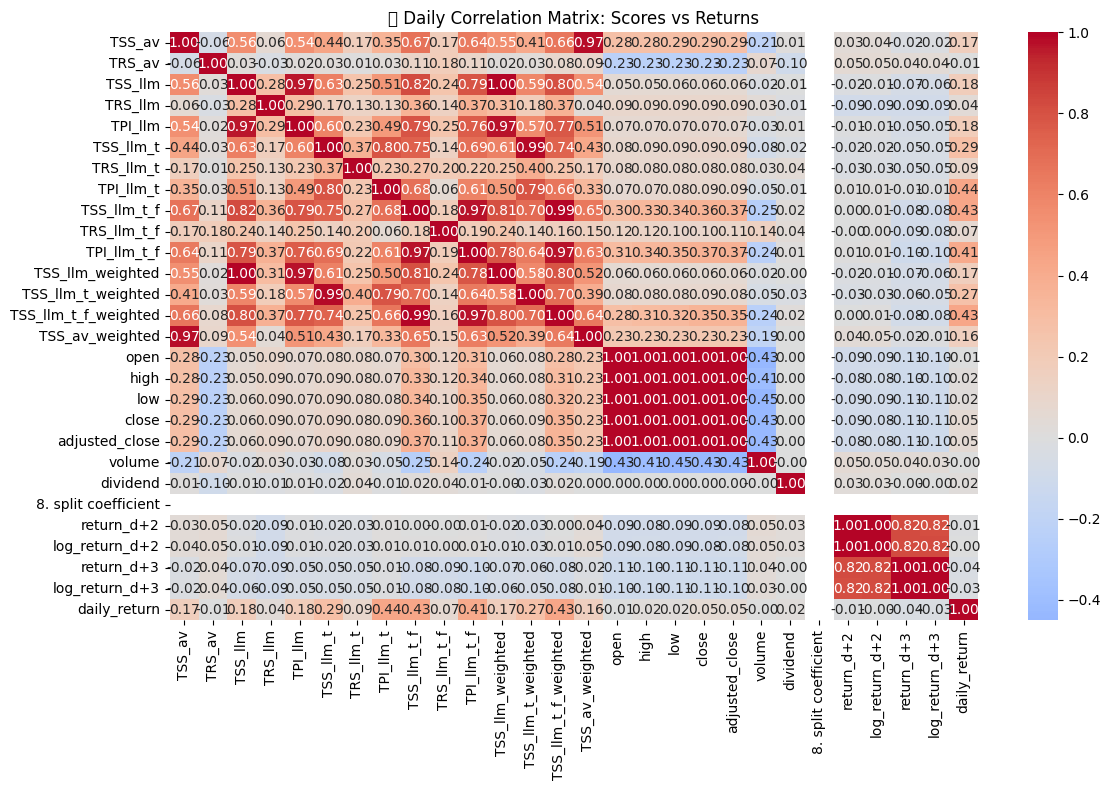

C:\Users\Victor\AppData\Local\Temp\ipykernel_28704\2036125985.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


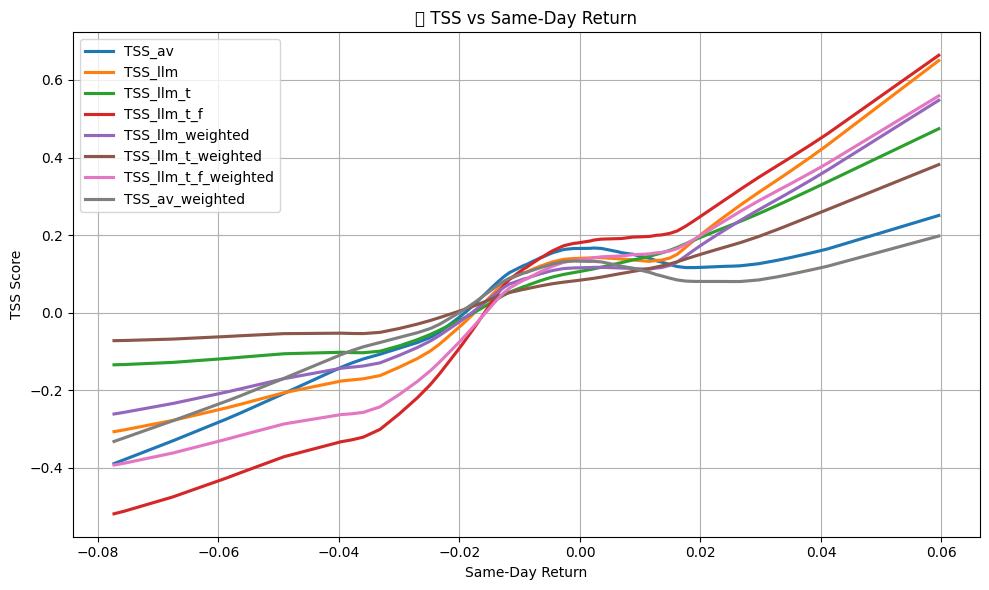

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) Ensure merged_daily has a daily_return column ───────────────────────
# If you haven’t already, compute:
# merged_daily['daily_return'] = merged_daily['adjusted_close'].pct_change()
# and then drop NaNs in that column before plotting.

df = merged_daily.copy()
df['daily_return'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['daily_return'])  # remove first row

# ─── 2) Correlation matrix ───────────────────────────────────────────────────
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("📊 Daily Correlation Matrix: Scores vs Returns")
plt.tight_layout()
plt.show()

# ─── 3) LOWESS‐smoothed regression plots ─────────────────────────────────────
x_vars = {
    "daily_return":     "Same‐Day Return",
}

# Group your sentiment / relevance / impact score columns
score_groups = {
    "TSS": [c for c in df.columns if c.startswith("TSS_")]
    # "TRS": [c for c in df.columns if c.startswith("TRS_")],
    # "TPI": [c for c in df.columns if c.startswith("TPI_")]
}

for score_type, cols in score_groups.items():
    for x_col, x_label in x_vars.items():
        if x_col not in df.columns:
            continue

        sub = df.dropna(subset=[x_col] + cols)
        if sub.empty:
            continue

        plt.figure(figsize=(10, 6))
        for score_col in cols:
            sns.regplot(
                data=sub,
                x=x_col,
                y=score_col,
                lowess=True,
                scatter=False,
                label=score_col
            )

        plt.xlabel(x_label)
        plt.ylabel(f"{score_type} Score")
        plt.title(f"📈 {score_type} vs {x_label}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


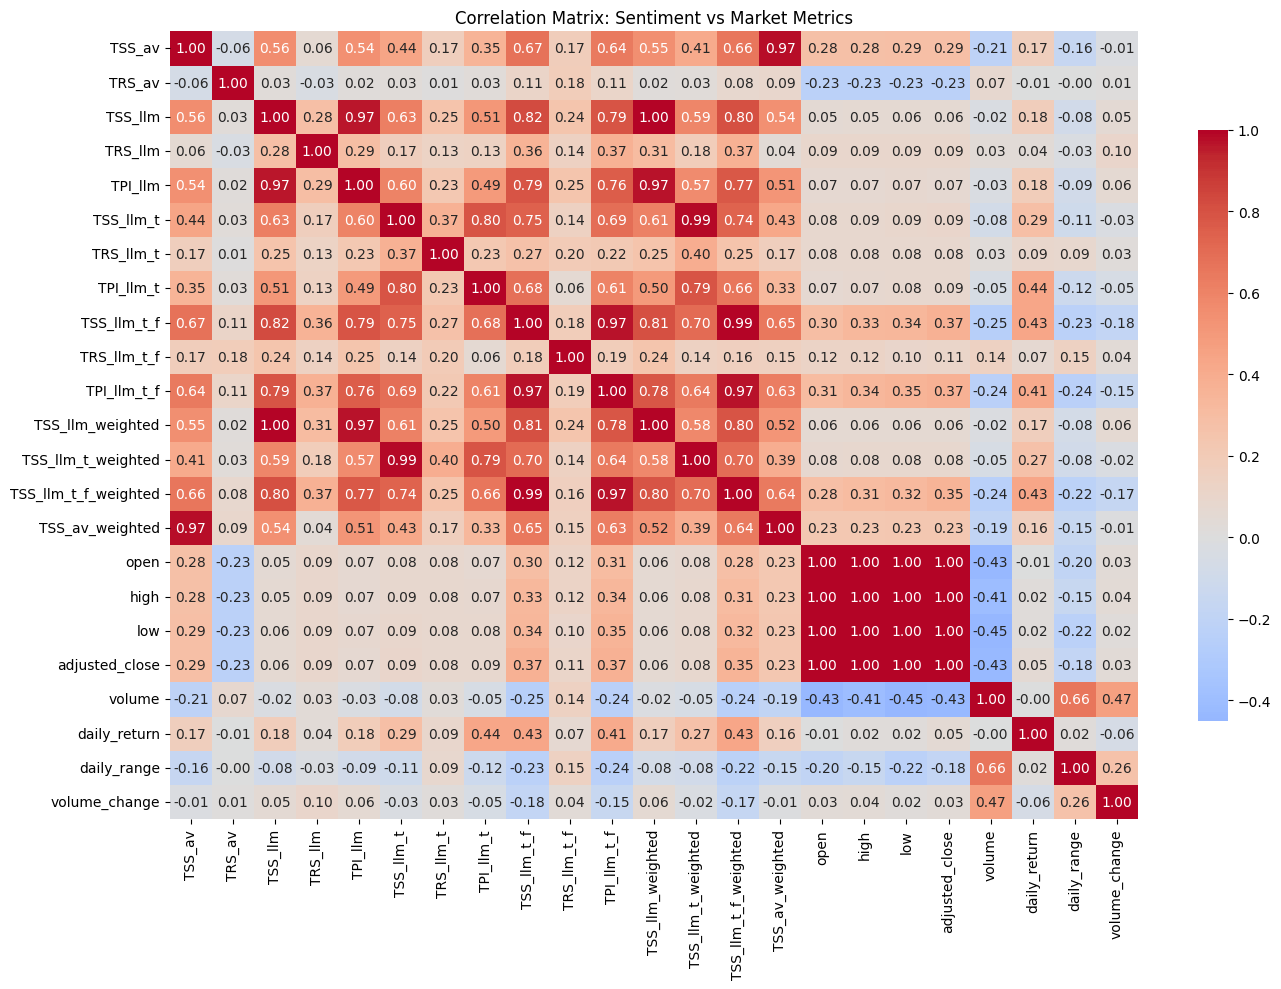

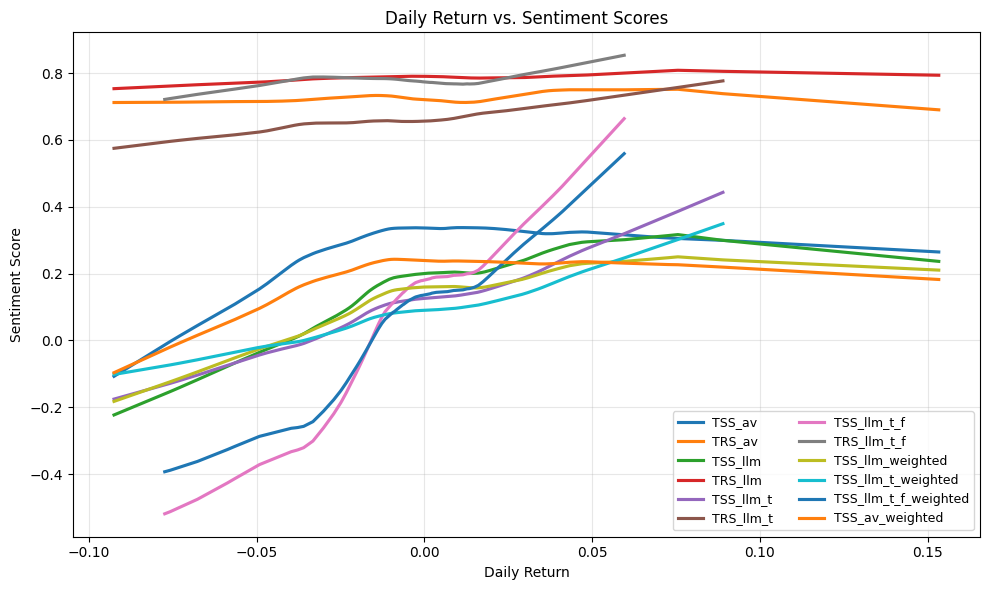

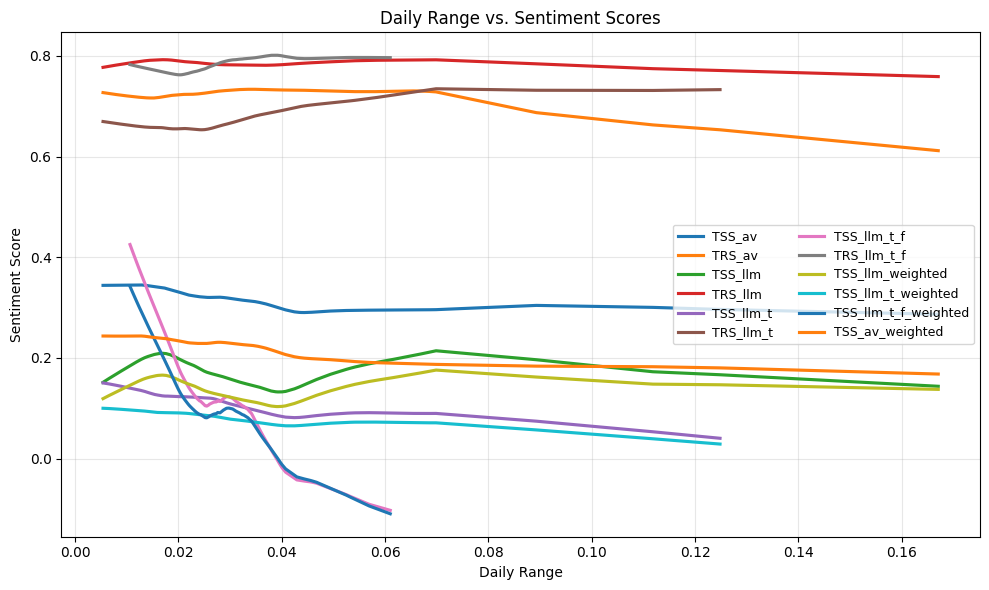

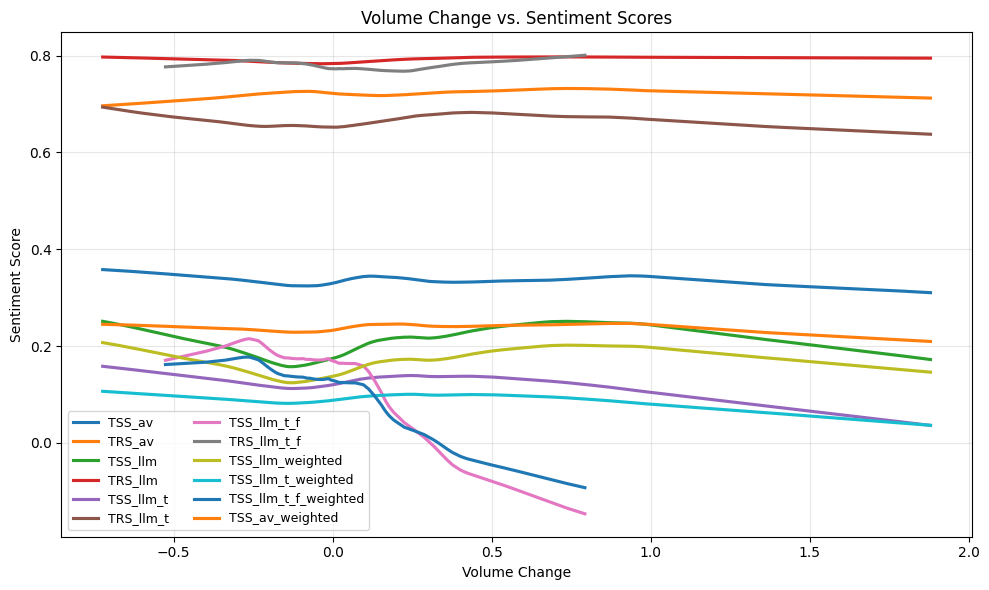

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_prices

# 1) Ensure your sentiment DataFrame has a datetime 'day_date'
daily_agg_comb['day_date'] = pd.to_datetime(daily_agg_comb['day_date'])

# 2) Load full daily price series for AAPL
df_prices = (
    load_prices(ticker="AAPL", frequency="daily", folder="stocks")
    .reset_index()
    .rename(columns={'date': 'day_date'})
)
df_prices['day_date'] = pd.to_datetime(df_prices['day_date'])

# 3) Merge sentiment + price
df = (
    daily_agg_comb
    .merge(
        df_prices[['day_date',
                   '1. open', '2. high', '3. low',
                   'adjusted_close', '6. volume']],
        on='day_date', how='inner'
    )
    .rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        'adjusted_close': 'adjusted_close',
        '6. volume': 'volume'
    })
    .sort_values('day_date')
    .reset_index(drop=True)
)

# 4) Compute daily_return from adjusted_close, plus other metrics
df['daily_return']  = df['adjusted_close'].pct_change()      # t → t+1 return
df['daily_range']   = (df['high'] - df['low']) / df['low']   # intraday swing
df['volume_change'] = df['volume'].pct_change()             # day-over-day volume change

# drop rows where any of these new metrics are NaN
df = df.dropna(subset=['daily_return','volume_change']).reset_index(drop=True)

# 5) Correlation heatmap among all numeric columns
plt.figure(figsize=(14,10))
sns.heatmap(
    df.select_dtypes(include='number').corr(),
    annot=True, fmt='.2f',
    cmap='coolwarm', center=0,
    cbar_kws={'shrink': .75}
)
plt.title("Correlation Matrix: Sentiment vs Market Metrics")
plt.tight_layout()
plt.show()

# 6) LOWESS scatter‐plots: each sentiment series vs each market variable
sentiment_cols = [c for c in df.columns if c.startswith(('TSS_','TRS_'))]
market_vars    = ['daily_return','daily_range','volume_change']

for mv in market_vars:
    plt.figure(figsize=(10,6))
    for sc in sentiment_cols:
        sns.regplot(
            x=mv, y=sc,
            data=df,
            lowess=True,
            scatter=False,
            label=sc
        )
    plt.xlabel(mv.replace('_',' ').title())
    plt.ylabel("Sentiment Score")
    plt.title(f"{mv.replace('_',' ').title()} vs. Sentiment Scores")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


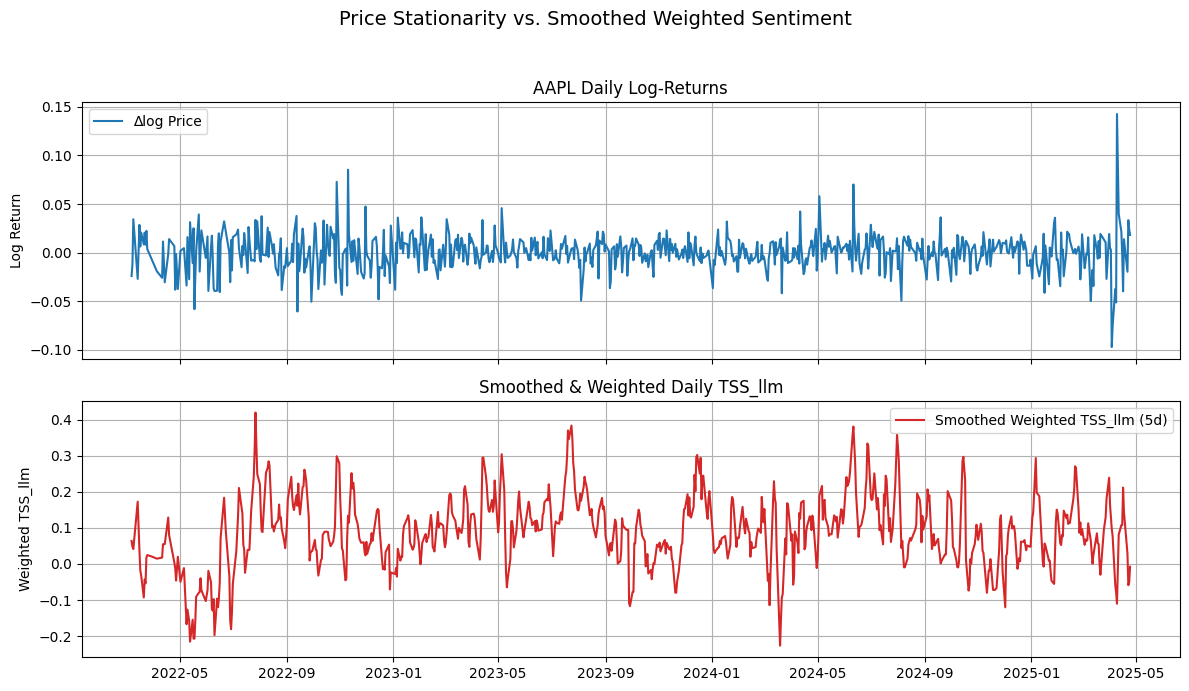

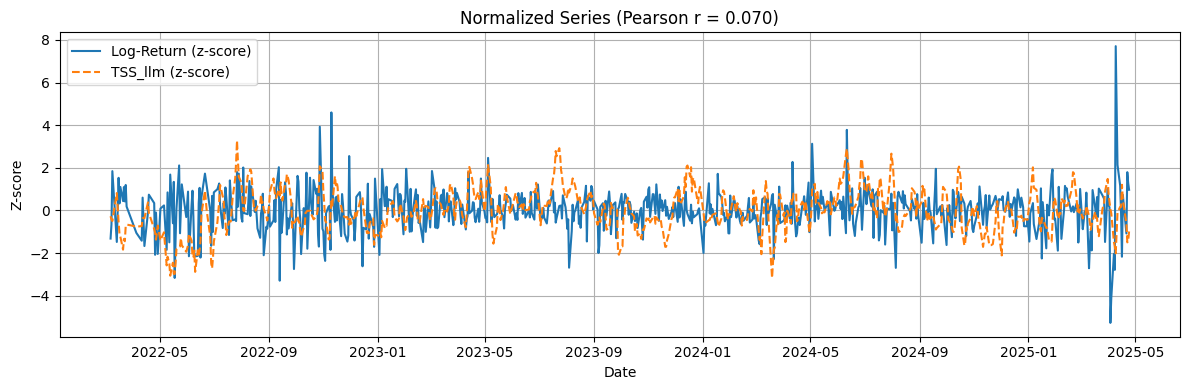

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# ── 1) Compute daily log‐returns for AAPL ─────────────────────────────────────
price_df = load_prices(ticker='AAPL', frequency='daily', folder='stocks').copy()
price_df.index.name = 'day_date'
price_df = price_df.sort_index()

# compute ∆log P = log(P_t / P_{t-1})
price_df['log_return'] = np.log(price_df['adjusted_close'] / price_df['adjusted_close'].shift(1))
price_df = price_df.dropna(subset=['log_return'])

# reset index into a column
price_returns = price_df[['log_return']].reset_index()

# ── 2) Build a **weighted, smoothed** daily-TSS_llm series ─────────────────────
#    (weight by relevance and smooth over a 5-day window)
# assume df_combined already loaded and has columns:
#     'day_date', 'TSS_llm', 'TRS_llm'
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_weighted'] = df_combined['TSS_llm'] * df_combined['TRS_llm']

# daily average + 5-day rolling mean
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_weighted':'smoothed_weighted_TSS_llm'})
)

# ── 3) Merge returns and sentiment on day_date ────────────────────────────────
merged = pd.merge(
    price_returns,
    tss_daily,
    on='day_date',
    how='inner'
).sort_values('day_date').reset_index(drop=True)

# ── 4) Plot time series ───────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged['day_date'], merged['log_return'], color='C0', label='∆log Price')
ax1.set_ylabel('Log Return')
ax1.set_title('AAPL Daily Log‐Returns')
ax1.grid(True)
ax1.legend()

ax2.plot(merged['day_date'], merged['smoothed_weighted_TSS_llm'],
         color='C3', label='Smoothed Weighted TSS_llm (5d)')
ax2.set_ylabel('Weighted TSS_llm')
ax2.set_title('Smoothed & Weighted Daily TSS_llm')
ax2.grid(True)
ax2.legend()

fig.suptitle('Price Stationarity vs. Smoothed Weighted Sentiment', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ── 5) Overlay in z‐score + report Pearson correlation ────────────────────────
p_z = (merged['log_return'] - merged['log_return'].mean()) / merged['log_return'].std()
s_z = (merged['smoothed_weighted_TSS_llm'] - 
       merged['smoothed_weighted_TSS_llm'].mean()) / merged['smoothed_weighted_TSS_llm'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged['day_date'], p_z, label='Log-Return (z-score)')
plt.plot(merged['day_date'], s_z, '--', label='TSS_llm (z-score)')
plt.title(f'Normalized Series (Pearson r = {corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


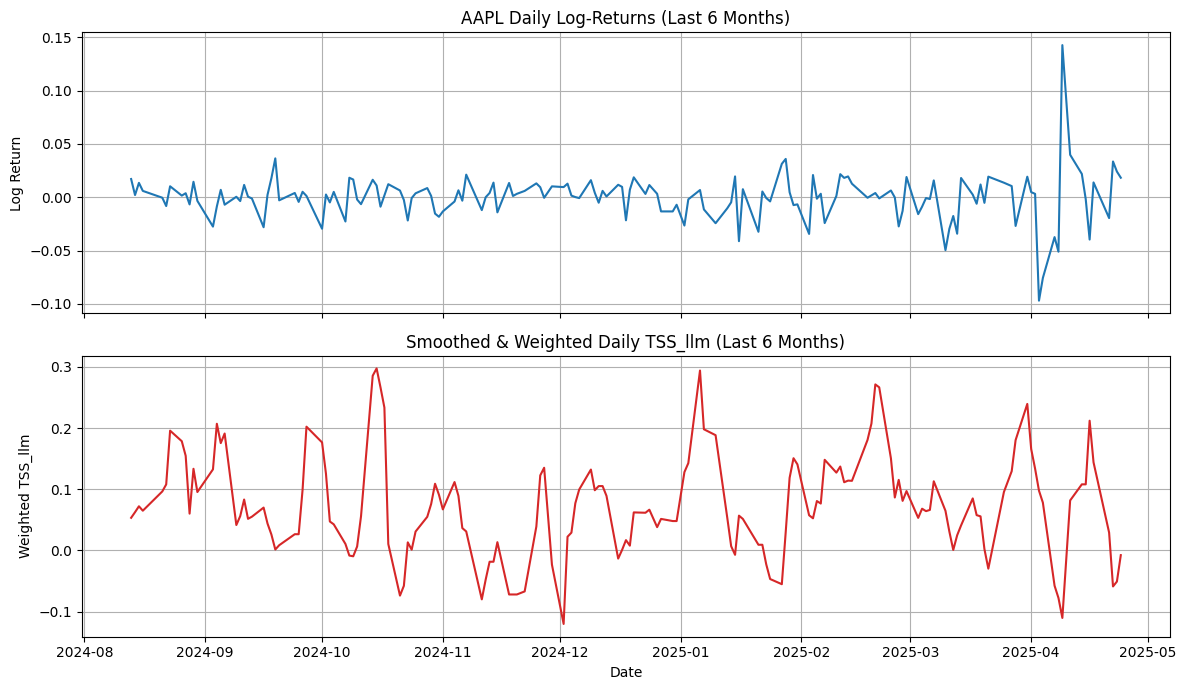

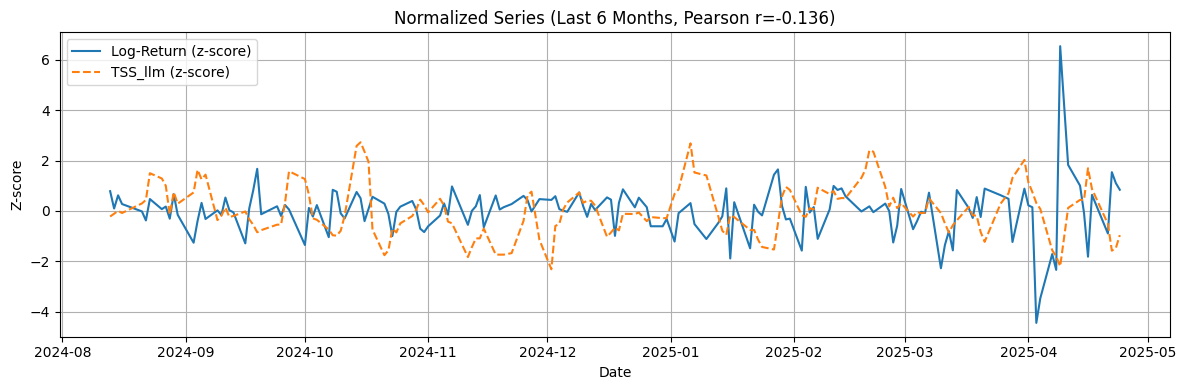

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# 1) Compute daily log‐returns for AAPL
price_df = load_prices(ticker='AAPL', frequency='daily', folder='stocks').copy()
price_df.index.name = 'day_date'
price_df = price_df.sort_index()
price_df['log_return'] = np.log(price_df['adjusted_close'] / price_df['adjusted_close'].shift(1))
price_returns = price_df[['log_return']].dropna().reset_index()

# 2) Build weighted, smoothed daily TSS_llm
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_weighted'] = df_combined['TSS_llm'] * df_combined['TRS_llm']
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_weighted':'smoothed_weighted_TSS_llm'})
)

# 3) Merge and keep last 6 months
merged = (
    pd.merge(price_returns, tss_daily, on='day_date', how='inner')
      .sort_values('day_date')
      .reset_index(drop=True)
)
cutoff = pd.Timestamp.today() - pd.DateOffset(months=9)
merged6m = merged[merged['day_date'] >= cutoff]

# 4) Plot time series over last 6 months
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged6m['day_date'], merged6m['log_return'], color='C0')
ax1.set_ylabel('Log Return')
ax1.set_title('AAPL Daily Log‐Returns (Last 6 Months)')
ax1.grid(True)

ax2.plot(merged6m['day_date'], merged6m['smoothed_weighted_TSS_llm'], color='C3')
ax2.set_ylabel('Weighted TSS_llm')
ax2.set_title('Smoothed & Weighted Daily TSS_llm (Last 6 Months)')
ax2.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 5) Overlay in z‐score + Pearson r (last 6 months)
p_z = (merged6m['log_return'] - merged6m['log_return'].mean()) / merged6m['log_return'].std()
s_z = (merged6m['smoothed_weighted_TSS_llm'] - merged6m['smoothed_weighted_TSS_llm'].mean()) / merged6m['smoothed_weighted_TSS_llm'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged6m['day_date'], p_z, label='Log-Return (z-score)')
plt.plot(merged6m['day_date'], s_z, '--', label='TSS_llm (z-score)')
plt.title(f'Normalized Series (Last 6 Months, Pearson r={corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **VAR**

Weighted es todos los modelos juntos, ahora seria interesante ver la robustez de todos los modelos

In [97]:
# --- 1) Merge `df_combined` with AAPL daily & weekly prices to get returns ---
df = df_combined.copy()
df['day_date'] = pd.to_datetime(df['day_date'])

# load daily adjusted closes
prices_d = (
    load_prices(ticker='AAPL', frequency='daily', folder='stocks')
    .reset_index()
    .rename(columns={'date':'day_date'})
)
prices_d['day_date'] = pd.to_datetime(prices_d['day_date'])

# merge + compute daily return
df = df.merge(prices_d[['day_date','adjusted_close']], on='day_date', how='inner')
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# compute weekly return
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_close = df.groupby('week')['adjusted_close'].last().rename('adj_w')
weekly_ret   = weekly_close.pct_change().rename('return_w')
weekly = pd.DataFrame({ 'adj_w': weekly_close, 'return_w': weekly_ret }).dropna().reset_index()

df = df.merge(weekly, on='week', how='inner').dropna(subset=['return_w'])

## *First Try*

VAR Daily
Daily VAR — lag=2, AIC=-23.85, BIC=-23.00


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


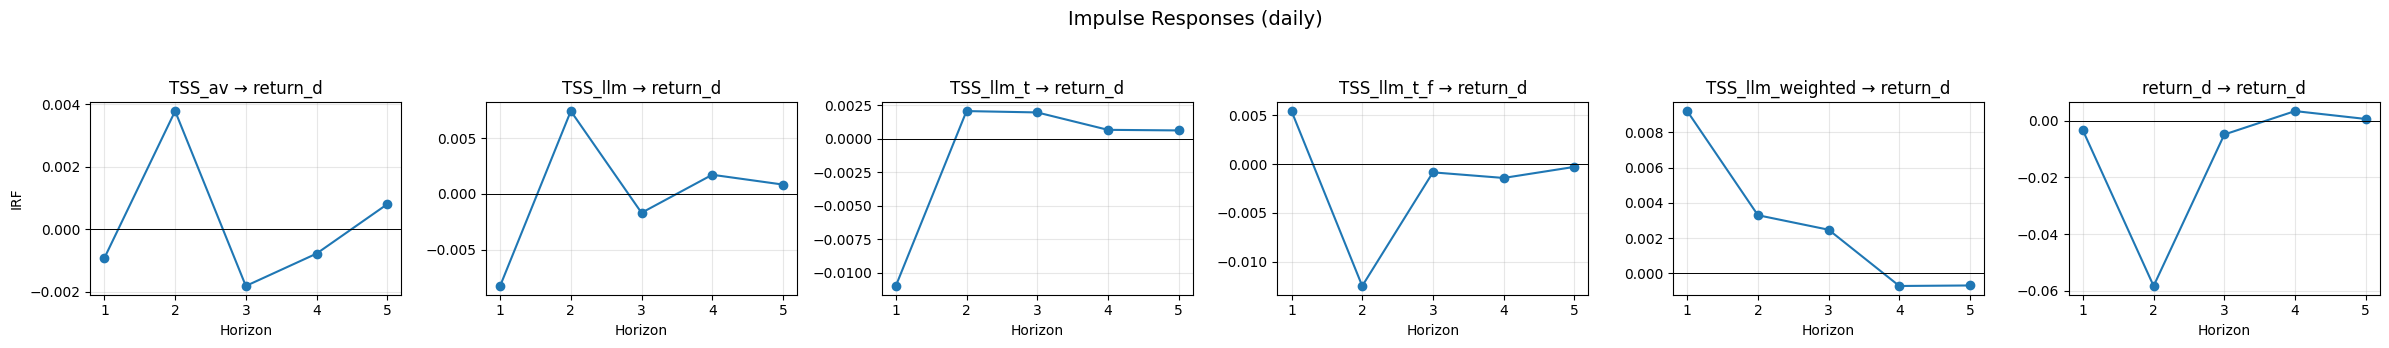

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_d
h+1 -0.328988  0.086055   0.140828     0.131087          0.066737 -0.001422
h+2  0.146085  0.121670   0.122624     0.157687          0.095894 -0.002887
h+3  0.014557  0.141572   0.115721     0.139790          0.117953 -0.001378
h+4 -0.063034  0.090705   0.079215     0.100606          0.077554  0.000114
h+5  0.031999  0.103640   0.086416     0.109982          0.087933  0.000394

VAR Daily - Order Reversed
Daily VAR — lag=2, AIC=-23.85, BIC=-23.00


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


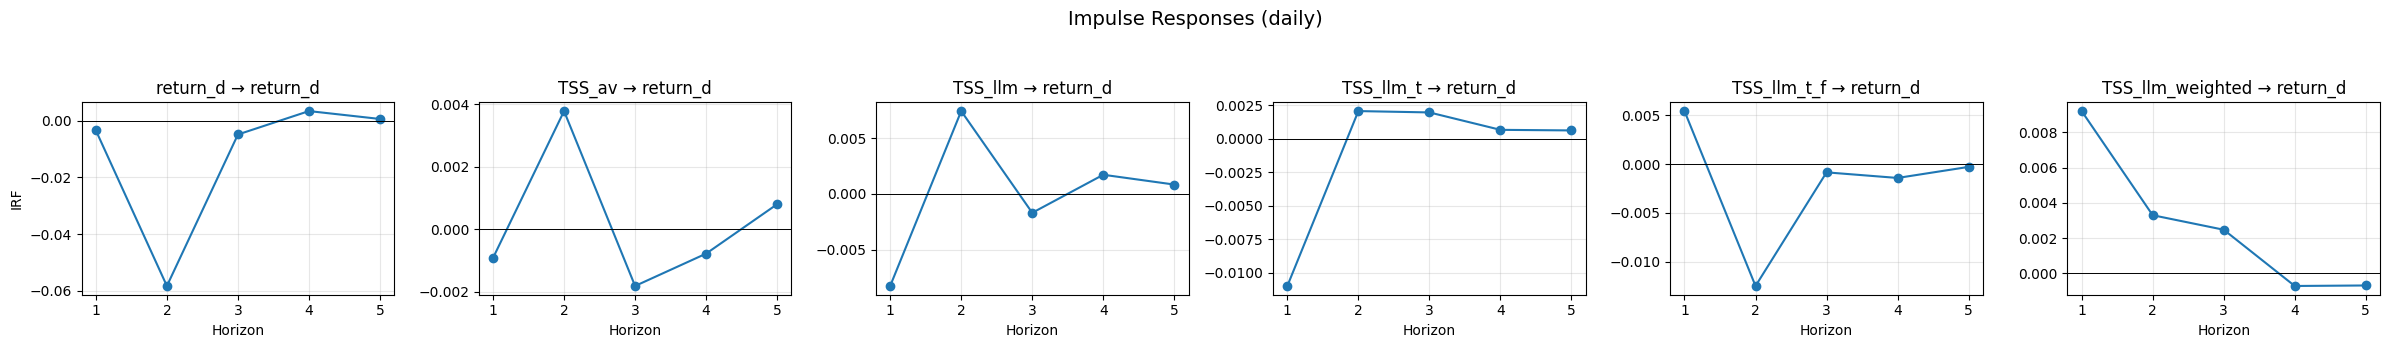

Forecast (next steps):


return_d    TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted
h+1 -0.001422 -0.328988  0.086055   0.140828     0.131087          0.066737
h+2 -0.002887  0.146085  0.121670   0.122624     0.157687          0.095894
h+3 -0.001378  0.014557  0.141572   0.115721     0.139790          0.117953
h+4  0.000114 -0.063034  0.090705   0.079215     0.100606          0.077554
h+5  0.000394  0.031999  0.103640   0.086416     0.109982          0.087933

VAR Weekly
Weekly VAR — lag=2, AIC=-24.45, BIC=-23.61


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


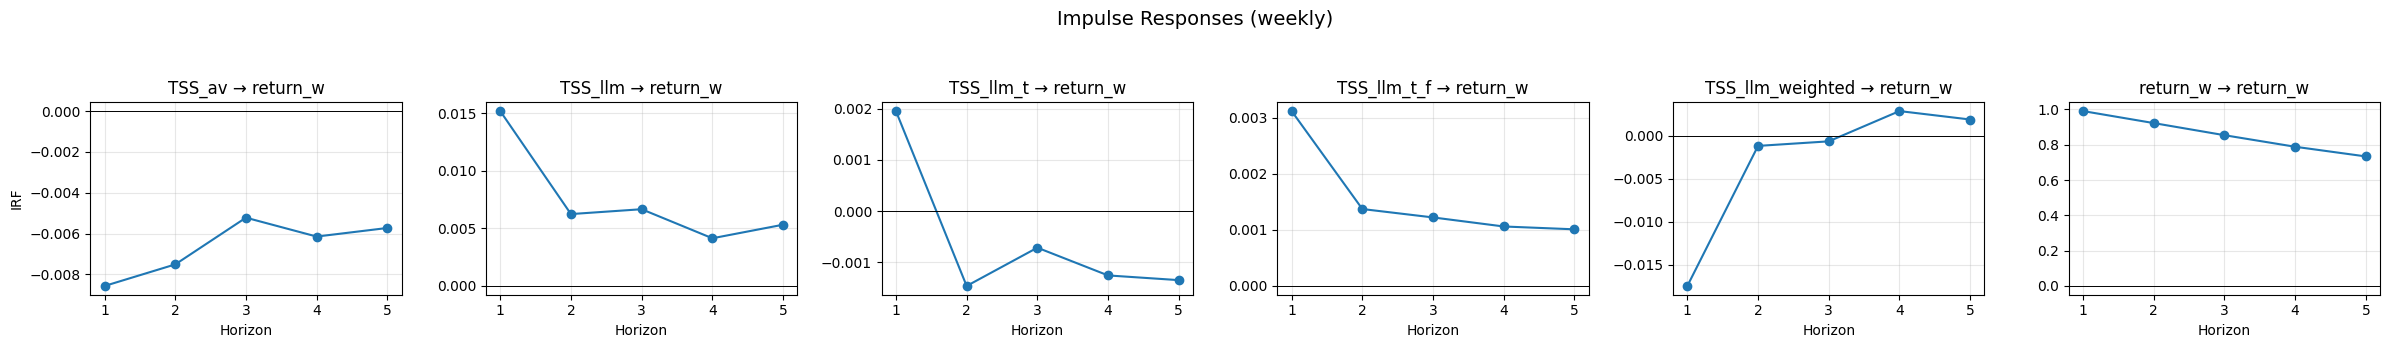

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_w
h+1 -0.327677  0.087688   0.147440     0.133904          0.066843 -0.025246
h+2  0.142207  0.118149   0.126275     0.154375          0.092435 -0.022505
h+3  0.014975  0.127282   0.115207     0.128443          0.105896 -0.020625
h+4 -0.063306  0.078489   0.079783     0.090995          0.066939 -0.019658
h+5  0.029740  0.088457   0.084592     0.097043          0.075190 -0.017666

VAR Weekly - Order Reversed
Weekly VAR — lag=2, AIC=-24.45, BIC=-23.61


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


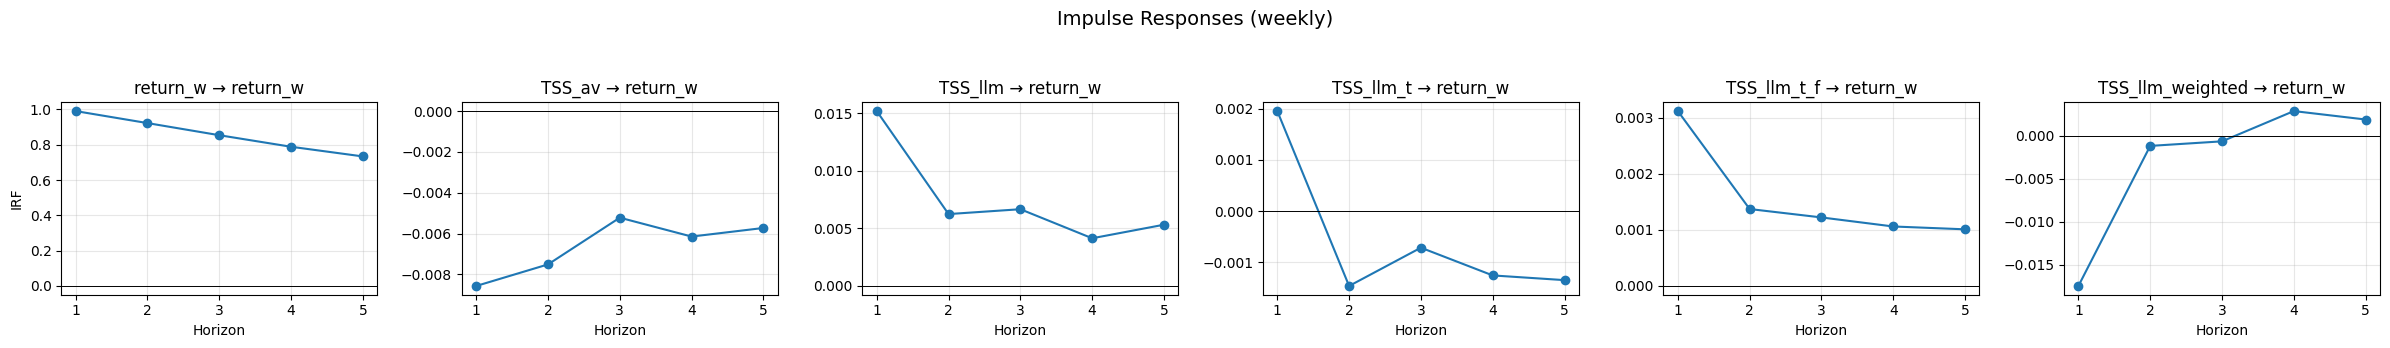

Forecast (next steps):


return_w    TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted
h+1 -0.025246 -0.327677  0.087688   0.147440     0.133904          0.066843
h+2 -0.022505  0.142207  0.118149   0.126275     0.154375          0.092435
h+3 -0.020625  0.014975  0.127282   0.115207     0.128443          0.105896
h+4 -0.019658 -0.063306  0.078489   0.079783     0.090995          0.066939
h+5 -0.017666  0.029740  0.088457   0.084592     0.097043          0.075190

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_prices

# --- 2) A generic VAR‐IRF function with variable‐ordering override ---
def run_var_grid(
    df,
    frequency='daily',
    var_order: list[str] | None = None,
    maxlags: int = 5,
    forecast_steps: int = 5
):
    """
    Fits a VAR on either daily or weekly data, then plots IRFs in a 1×N grid.
    If `var_order` is provided, uses exactly that order of endogenous vars.
    Otherwise defaults to [all TSS_… cols] + [return_d or return_w].
    """
    # pick time & return columns
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # candidate impulses
    tss_cols = [c for c in df.columns if c.startswith('TSS_')]

    # build endogenous ordering
    if var_order is None:
        var_order = tss_cols + [ret]
    else:
        # validate
        missing = [c for c in var_order if c not in df.columns]
        if missing:
            raise KeyError(f"these columns not in df: {missing}")

    # assemble VAR DataFrame
    cols = [tcol] + var_order
    df_var = df[cols].dropna().set_index(tcol)

    # stationarize non‐stationary series
    def make_stationary(x):
        y = x.copy()
        for col in x:
            if adfuller(x[col])[1] > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # fit VAR
    m = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic),1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # compute IRFs
    irf = res.irf(forecast_steps)
    irf_mat = irf.irfs       # shape (h+1, nvar, nvar)
    nvar    = len(var_order)

    # plot 1×nvar grid
    fig, axes = plt.subplots(1, nvar, figsize=(4*nvar,3.5), squeeze=False)
    for i,var in enumerate(var_order):
        x = np.arange(1,forecast_steps+1)
        y = irf_mat[1:, var_order.index(ret), i]   # response = ret, impulse=var
        ax = axes[0,i]
        ax.plot(x,y,marker='o')
        ax.axhline(0,color='k',lw=0.7)
        ax.set_title(f"{var} → {ret}")
        ax.set_xlabel("Horizon")
        if i==0: ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)
    fig.suptitle(f"Impulse Responses ({frequency})",fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    # optional numeric forecast
    fc = res.forecast(df_s.values[-lag:], steps=forecast_steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns, index=[f"h+{k}" for k in range(1,forecast_steps+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── 3) Run with TWO orderings ─────────────────────────────────────────────

# (a) default: all TSS_* first, then the return
print("VAR Daily")
run_var_grid(df, frequency='daily', var_order=None, forecast_steps=5)

print("VAR Daily - Order Reversed")
rev_order_daily  = ['return_d'] + [c for c in df.columns if c.startswith('TSS_')]
run_var_grid(df, frequency='daily',   var_order=rev_order_daily,  forecast_steps=5)


print("VAR Weekly")
run_var_grid(df, frequency='weekly', var_order=None, forecast_steps=5)

print("VAR Weekly - Order Reversed")
rev_order_weekly = ['return_w'] + [c for c in df.columns if c.startswith('TSS_')]
run_var_grid(df, frequency='weekly',  var_order=rev_order_weekly, forecast_steps=5)


# **VAR** - TSS - Ticker Sentiment Score

VAR Daily (TSS_* → return)
Daily VAR — lag=2, AIC=-23.85, BIC=-23.00


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


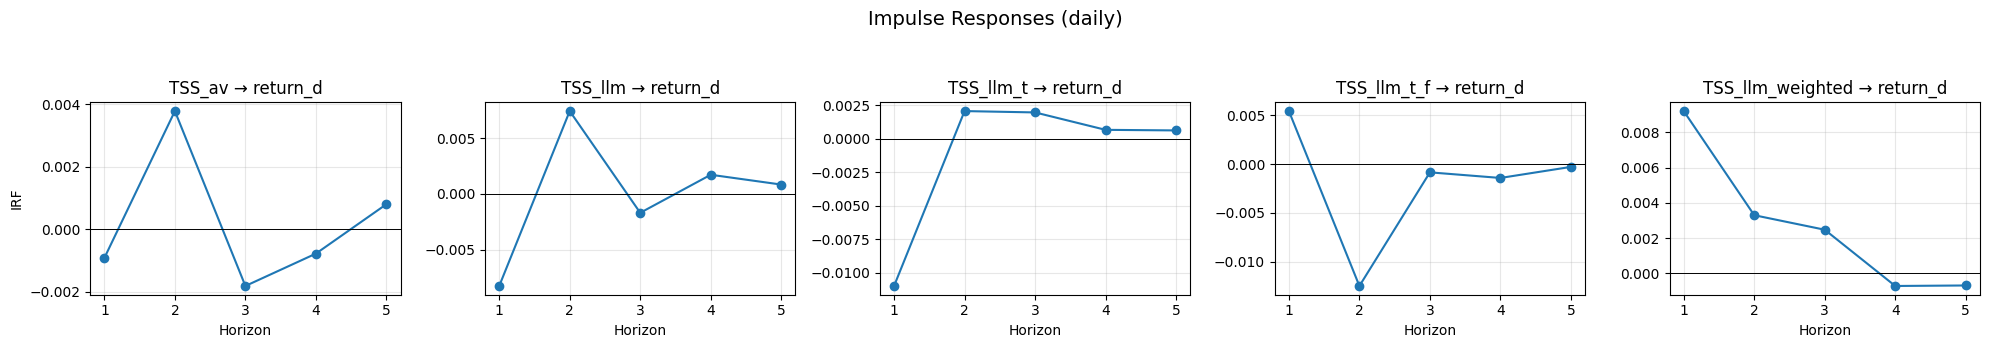

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_d
h+1 -0.328988  0.086055   0.140828     0.131087          0.066737 -0.001422
h+2  0.146085  0.121670   0.122624     0.157687          0.095894 -0.002887
h+3  0.014557  0.141572   0.115721     0.139790          0.117953 -0.001378
h+4 -0.063034  0.090705   0.079215     0.100606          0.077554  0.000114
h+5  0.031999  0.103640   0.086416     0.109982          0.087933  0.000394

VAR Daily (orden invertido, aún sin return→return)
Daily VAR — lag=2, AIC=-23.85, BIC=-23.00


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


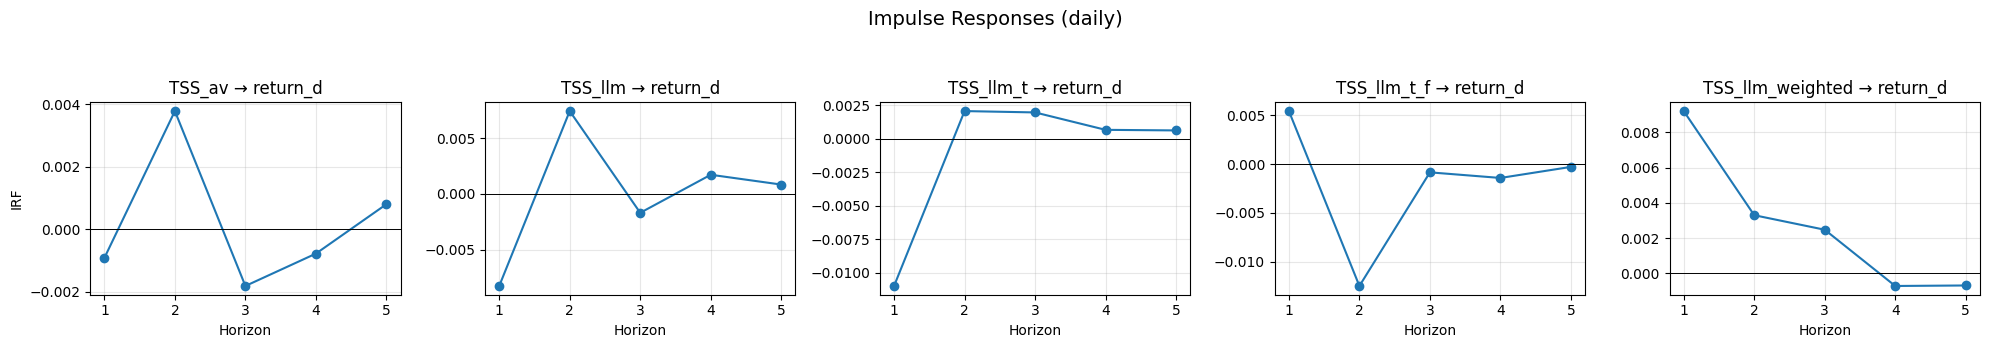

Forecast (next steps):


return_d    TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted
h+1 -0.001422 -0.328988  0.086055   0.140828     0.131087          0.066737
h+2 -0.002887  0.146085  0.121670   0.122624     0.157687          0.095894
h+3 -0.001378  0.014557  0.141572   0.115721     0.139790          0.117953
h+4  0.000114 -0.063034  0.090705   0.079215     0.100606          0.077554
h+5  0.000394  0.031999  0.103640   0.086416     0.109982          0.087933

VAR Weekly (TSS_* → return)
Weekly VAR — lag=2, AIC=-24.45, BIC=-23.61


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


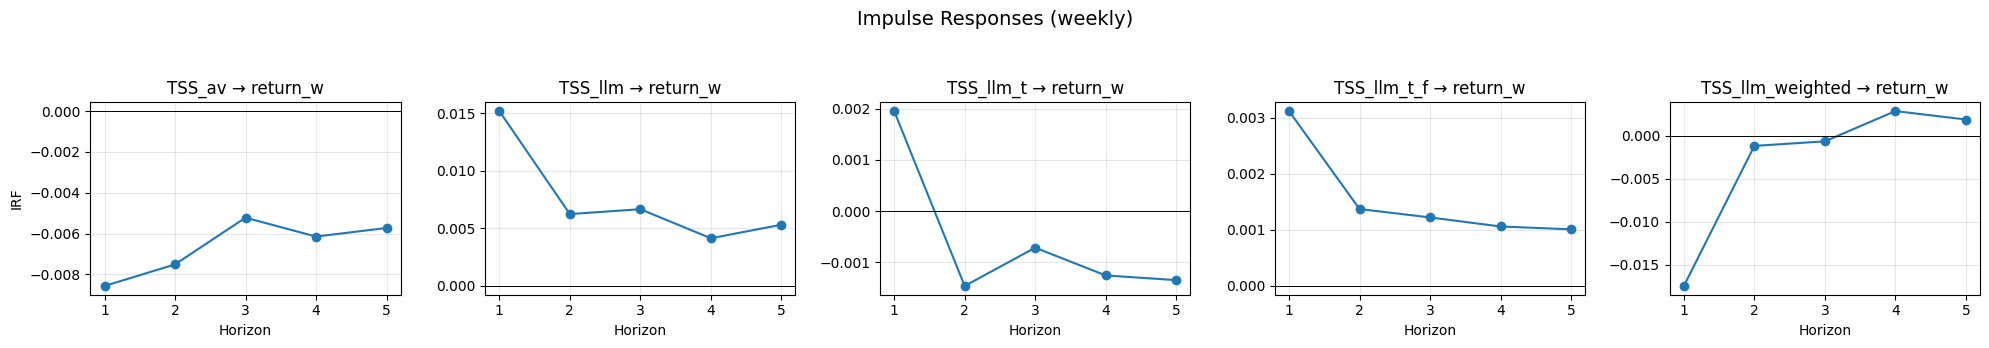

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_w
h+1 -0.327677  0.087688   0.147440     0.133904          0.066843 -0.025246
h+2  0.142207  0.118149   0.126275     0.154375          0.092435 -0.022505
h+3  0.014975  0.127282   0.115207     0.128443          0.105896 -0.020625
h+4 -0.063306  0.078489   0.079783     0.090995          0.066939 -0.019658
h+5  0.029740  0.088457   0.084592     0.097043          0.075190 -0.017666

VAR Weekly (orden invertido, aún sin return→return)
Weekly VAR — lag=2, AIC=-24.45, BIC=-23.61


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


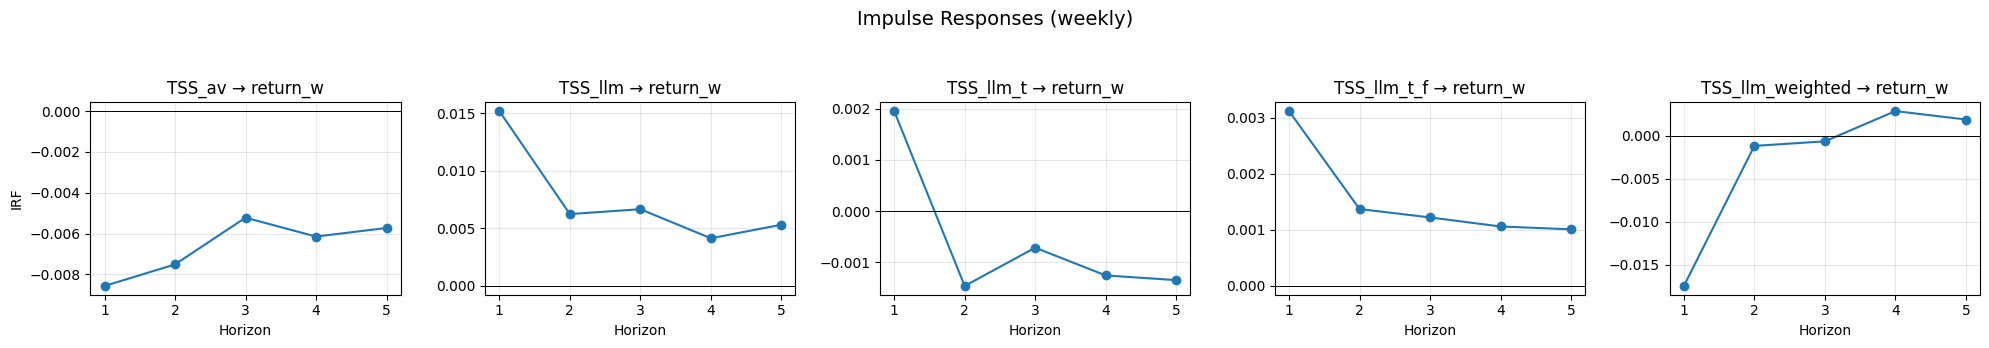

Forecast (next steps):


return_w    TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted
h+1 -0.025246 -0.327677  0.087688   0.147440     0.133904          0.066843
h+2 -0.022505  0.142207  0.118149   0.126275     0.154375          0.092435
h+3 -0.020625  0.014975  0.127282   0.115207     0.128443          0.105896
h+4 -0.019658 -0.063306  0.078489   0.079783     0.090995          0.066939
h+5 -0.017666  0.029740  0.088457   0.084592     0.097043          0.075190

In [99]:
def run_var_grid(
    df,
    frequency='daily',
    var_order: list[str] | None = None,
    maxlags: int = 5,
    forecast_steps: int = 5
):
    """
    Fits a VAR on either daily or weekly data, then plots IRFs en una grilla 1×N,
    pero sin el plot return→return: solo cada TSS_* → return.
    """
    # elegir columnas de tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    tss_cols = [c for c in df.columns if c.startswith('TSS_')]

    # orden endógeno: o bien dado, o bien todos los TSS_* + retorno
    if var_order is None:
        var_order = tss_cols + [ret]
    else:
        missing = [c for c in var_order if c not in df.columns]
        if missing:
            raise KeyError(f"estas columnas no existen: {missing}")

    # armar df para VAR
    cols = [tcol] + var_order
    df_var = df[cols].dropna().set_index(tcol)

    # diferenciar series no estacionarias
    def make_stationary(x):
        y = x.copy()
        for col in x:
            if adfuller(x[col])[1] > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # estimar VAR
    m = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic), 1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # calcular IRFs
    irf = res.irf(forecast_steps)
    irf_mat = irf.irfs       # shape (h+1, nvar, nvar)

    # solo impulsos de los TSS_* (no el return→return)
    impulse_vars = [v for v in var_order if v != ret]
    nimp = len(impulse_vars)

    # grilla 1×nimp
    fig, axes = plt.subplots(1, nimp, figsize=(4*nimp,3.5), squeeze=False)
    x = np.arange(1, forecast_steps+1)
    for i, var in enumerate(impulse_vars):
        # respuesta de 'ret' al impulso 'var'
        y = irf_mat[1:, var_order.index(ret), var_order.index(var)]
        ax = axes[0,i]
        ax.plot(x, y, marker='o')
        ax.axhline(0, color='k', lw=0.7)
        ax.set_title(f"{var} → {ret}")
        ax.set_xlabel("Horizon")
        if i==0:
            ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)

    fig.suptitle(f"Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    # (opcional) tabla numérica de forecast
    fc = res.forecast(df_s.values[-lag:], steps=forecast_steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1, forecast_steps+1)])
    print("Forecast (next steps):")
    display(fc_df)

print("VAR Daily (TSS_* → return)")
run_var_grid(df, frequency='daily', var_order=None, forecast_steps=5)

print("VAR Daily (orden invertido, aún sin return→return)")
rev_order_daily = ['return_d'] + [c for c in df.columns if c.startswith('TSS_')]
run_var_grid(df, frequency='daily', var_order=rev_order_daily, forecast_steps=5)

print("VAR Weekly (TSS_* → return)")
run_var_grid(df, frequency='weekly', var_order=None, forecast_steps=5)

print("VAR Weekly (orden invertido, aún sin return→return)")
rev_order_weekly = ['return_w'] + [c for c in df.columns if c.startswith('TSS_')]
run_var_grid(df, frequency='weekly', var_order=rev_order_weekly, forecast_steps=5)

# **VAR** - TRS - Ticker Sentiment Relevance

VAR Daily (TRS_* → return)
Daily VAR — lag=1, AIC=-20.85, BIC=-20.53


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


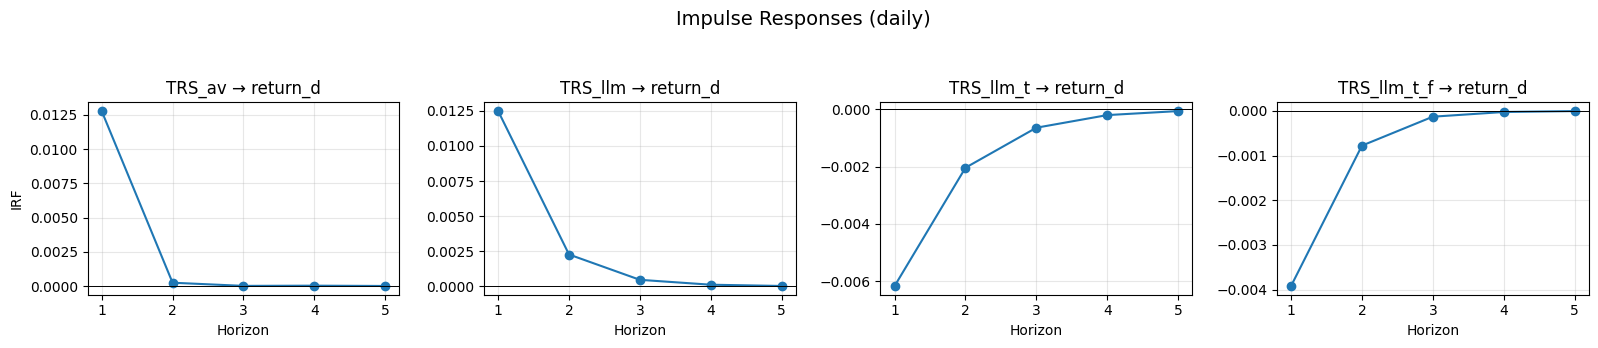

Forecast (next steps):


TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f  return_d
h+1  0.734015  0.650540   0.625923     0.705577 -0.002264
h+2  0.737725  0.626834   0.568014     0.690367 -0.000219
h+3  0.736577  0.624256   0.552598     0.687233 -0.000062
h+4  0.736217  0.624511   0.548456     0.686563 -0.000003
h+5  0.736078  0.624730   0.547282     0.686328  0.000024

VAR Daily (orden invertido, aún sin return→return)
Daily VAR — lag=1, AIC=-20.85, BIC=-20.53


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


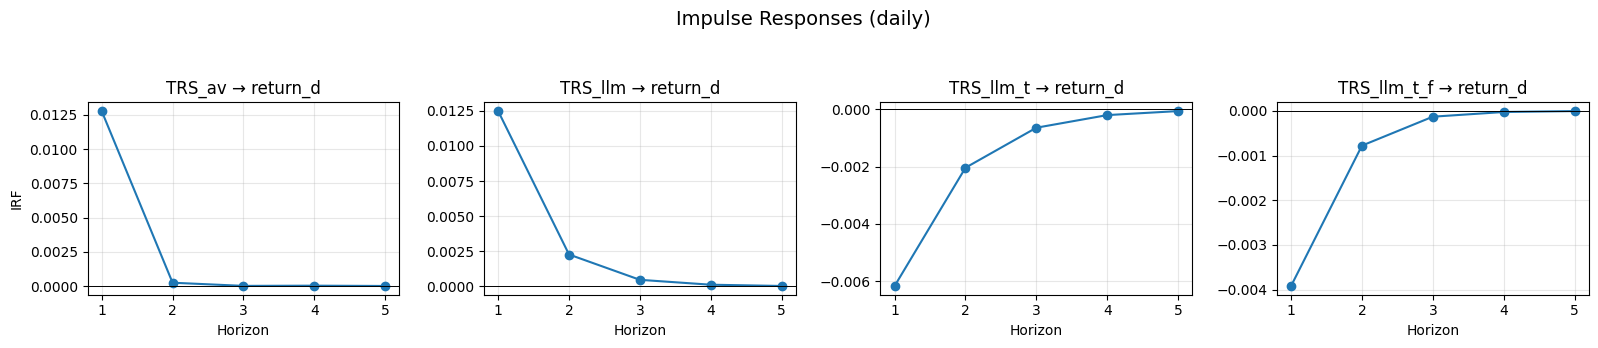

Forecast (next steps):


return_d    TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f
h+1 -0.002264  0.734015  0.650540   0.625923     0.705577
h+2 -0.000219  0.737725  0.626834   0.568014     0.690367
h+3 -0.000062  0.736577  0.624256   0.552598     0.687233
h+4 -0.000003  0.736217  0.624511   0.548456     0.686563
h+5  0.000024  0.736078  0.624730   0.547282     0.686328

VAR Weekly (TRS_* → return)
Weekly VAR — lag=1, AIC=-21.49, BIC=-21.16


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


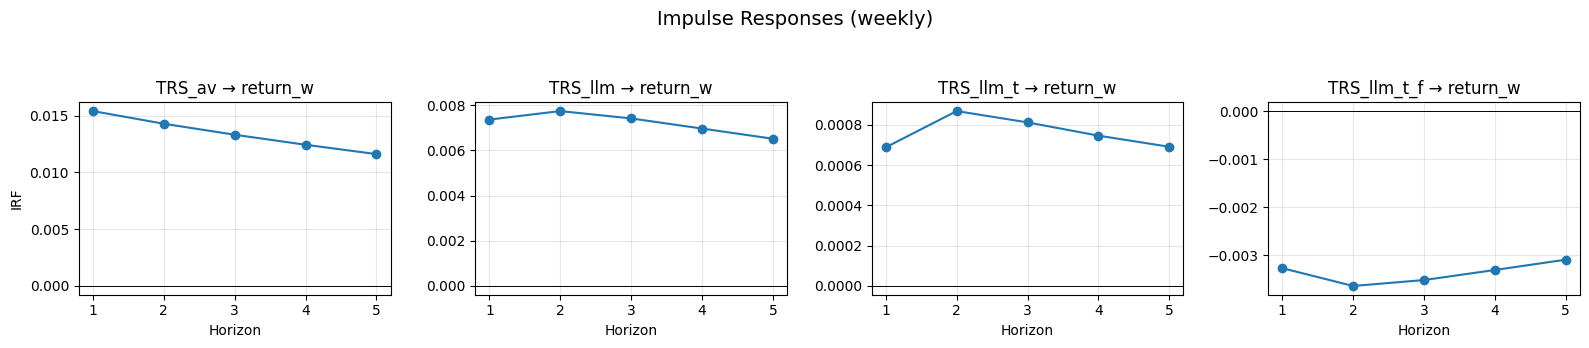

Forecast (next steps):


TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f  return_w
h+1  0.732569  0.652750   0.632059     0.706355 -0.024095
h+2  0.733960  0.630102   0.582722     0.690634 -0.022131
h+3  0.733521  0.628478   0.569952     0.688513 -0.020425
h+4  0.733408  0.628592   0.565755     0.687989 -0.018854
h+5  0.733490  0.628540   0.563748     0.687735 -0.017389

VAR Weekly (orden invertido, aún sin return→return)
Weekly VAR — lag=1, AIC=-21.49, BIC=-21.16


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


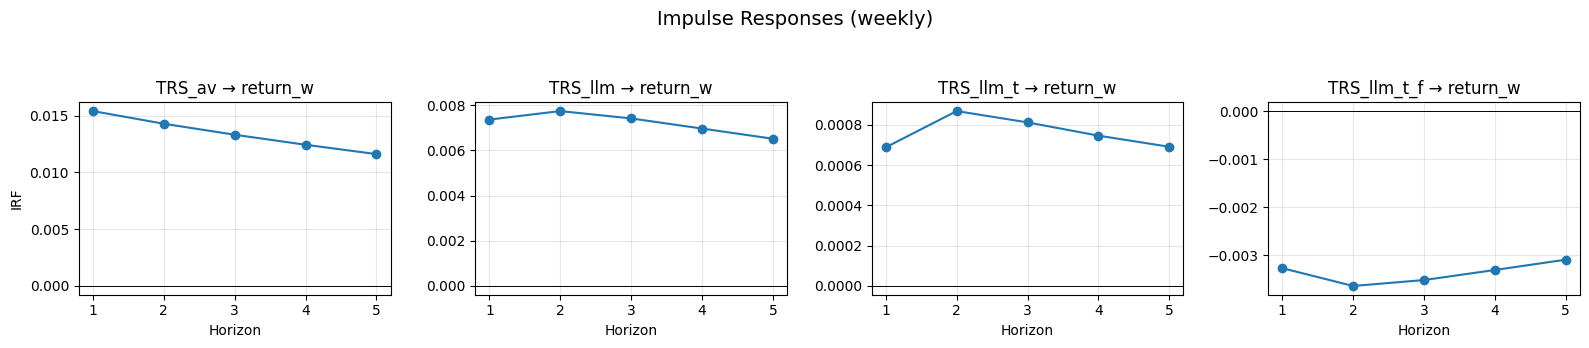

Forecast (next steps):


return_w    TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f
h+1 -0.024095  0.732569  0.652750   0.632059     0.706355
h+2 -0.022131  0.733960  0.630102   0.582722     0.690634
h+3 -0.020425  0.733521  0.628478   0.569952     0.688513
h+4 -0.018854  0.733408  0.628592   0.565755     0.687989
h+5 -0.017389  0.733490  0.628540   0.563748     0.687735

In [100]:
def run_var_grid(
    df,
    frequency='daily',
    var_order: list[str] | None = None,
    maxlags: int = 5,
    forecast_steps: int = 5
):
    """
    Fits a VAR on either daily or weekly data, then plots IRFs en una grilla 1×N,
    pero sin el plot return→return: solo cada TRS_* → return.
    """
    # elegir columnas de tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    trs_cols = [c for c in df.columns if c.startswith('TRS_')]

    # orden endógeno: o bien dado, o bien todos los TRS_* + retorno
    if var_order is None:
        var_order = trs_cols + [ret]
    else:
        missing = [c for c in var_order if c not in df.columns]
        if missing:
            raise KeyError(f"estas columnas no existen: {missing}")

    # armar df para VAR
    cols = [tcol] + var_order
    df_var = df[cols].dropna().set_index(tcol)

    # diferenciar series no estacionarias
    def make_stationary(x):
        y = x.copy()
        for col in x:
            if adfuller(x[col])[1] > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # estimar VAR
    m = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic), 1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # calcular IRFs
    irf = res.irf(forecast_steps)
    irf_mat = irf.irfs       # shape (h+1, nvar, nvar)

    # solo impulsos de los TRS_* (no el return→return)
    impulse_vars = [v for v in var_order if v != ret]
    nimp = len(impulse_vars)

    # grilla 1×nimp
    fig, axes = plt.subplots(1, nimp, figsize=(4*nimp,3.5), squeeze=False)
    x = np.arange(1, forecast_steps+1)
    for i, var in enumerate(impulse_vars):
        # respuesta de 'ret' al impulso 'var'
        y = irf_mat[1:, var_order.index(ret), var_order.index(var)]
        ax = axes[0,i]
        ax.plot(x, y, marker='o')
        ax.axhline(0, color='k', lw=0.7)
        ax.set_title(f"{var} → {ret}")
        ax.set_xlabel("Horizon")
        if i==0:
            ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)

    fig.suptitle(f"Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    # (opcional) tabla numérica de forecast
    fc = res.forecast(df_s.values[-lag:], steps=forecast_steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1, forecast_steps+1)])
    print("Forecast (next steps):")
    display(fc_df)

print("VAR Daily (TRS_* → return)")
run_var_grid(df, frequency='daily', var_order=None, forecast_steps=5)

print("VAR Daily (orden invertido, aún sin return→return)")
rev_order_daily = ['return_d'] + [c for c in df.columns if c.startswith('TRS_')]
run_var_grid(df, frequency='daily', var_order=rev_order_daily, forecast_steps=5)

print("VAR Weekly (TRS_* → return)")
run_var_grid(df, frequency='weekly', var_order=None, forecast_steps=5)

print("VAR Weekly (orden invertido, aún sin return→return)")
rev_order_weekly = ['return_w'] + [c for c in df.columns if c.startswith('TRS_')]
run_var_grid(df, frequency='weekly', var_order=rev_order_weekly, forecast_steps=5)

# **VAR** - TPI - Ticker Price Impact

VAR Daily (TPI_* → return)
Daily VAR — lag=3, AIC=-16.47, BIC=-15.91


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


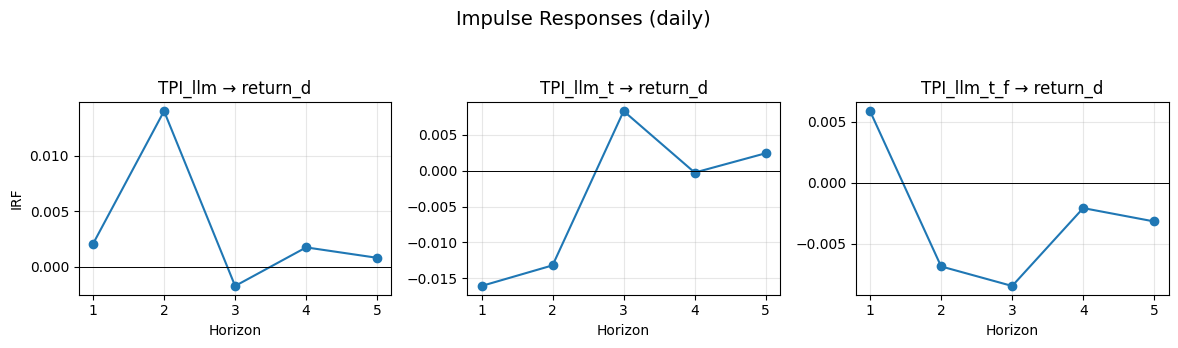

Forecast (next steps):


TPI_llm  TPI_llm_t  TPI_llm_t_f  return_d
h+1  0.043776  -0.002031     0.056767  0.005858
h+2  0.061533   0.036847     0.203114 -0.004732
h+3  0.100539   0.062506     0.189133 -0.002886
h+4  0.053449   0.017139     0.095699 -0.000797
h+5  0.056367   0.029235     0.119582 -0.001346

VAR Daily (orden invertido, aún sin return→return)
Daily VAR — lag=3, AIC=-16.47, BIC=-15.91


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


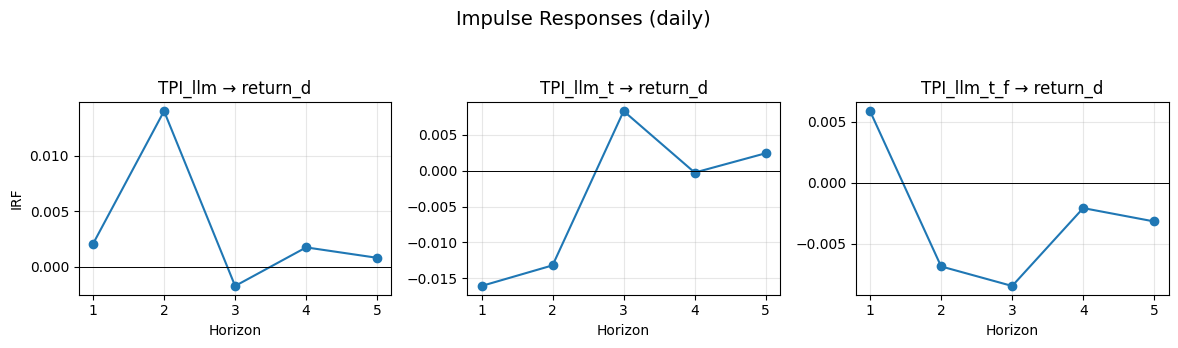

Forecast (next steps):


return_d   TPI_llm  TPI_llm_t  TPI_llm_t_f
h+1  0.005858  0.043776  -0.002031     0.056767
h+2 -0.004732  0.061533   0.036847     0.203114
h+3 -0.002886  0.100539   0.062506     0.189133
h+4 -0.000797  0.053449   0.017139     0.095699
h+5 -0.001346  0.056367   0.029235     0.119582

VAR Weekly (TPI_* → return)
Weekly VAR — lag=3, AIC=-17.03, BIC=-16.46


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


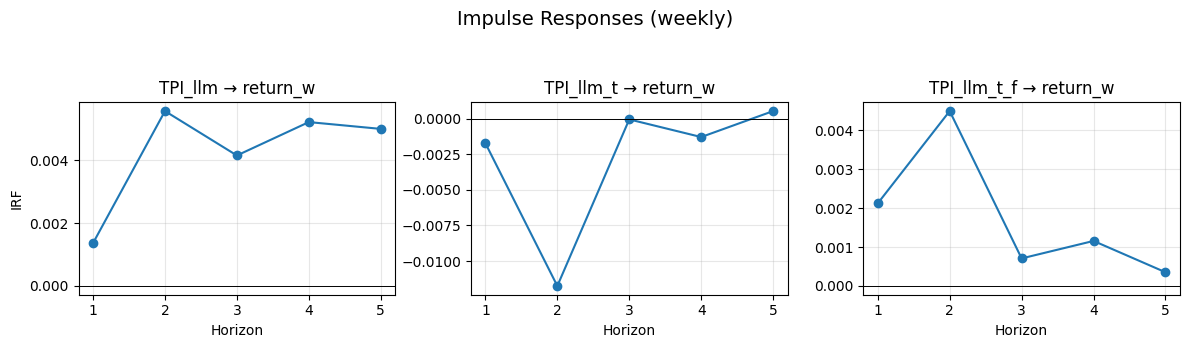

Forecast (next steps):


TPI_llm  TPI_llm_t  TPI_llm_t_f  return_w
h+1  0.033172  -0.002942     0.053262 -0.017620
h+2  0.053167   0.036472     0.196225 -0.016330
h+3  0.072857   0.052413     0.175867 -0.015335
h+4  0.039250   0.021360     0.091312 -0.013756
h+5  0.038438   0.027163     0.107797 -0.012696

VAR Weekly (orden invertido, aún sin return→return)
Weekly VAR — lag=3, AIC=-17.03, BIC=-16.46


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


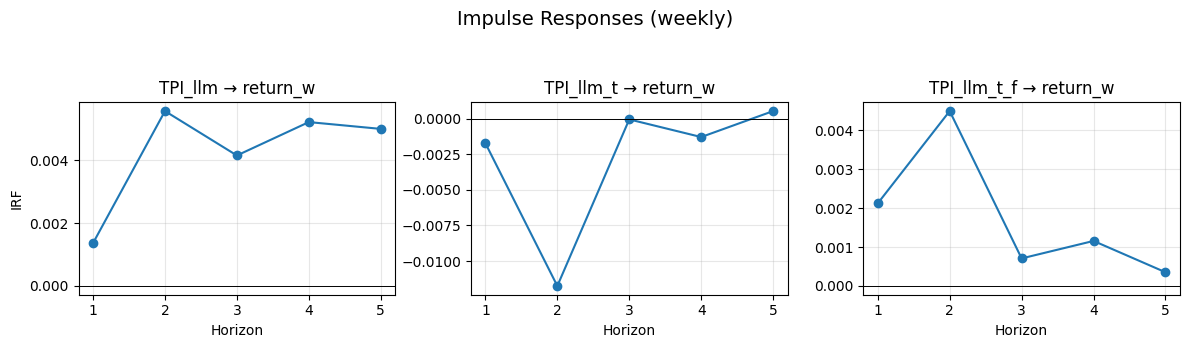

Forecast (next steps):


return_w   TPI_llm  TPI_llm_t  TPI_llm_t_f
h+1 -0.017620  0.033172  -0.002942     0.053262
h+2 -0.016330  0.053167   0.036472     0.196225
h+3 -0.015335  0.072857   0.052413     0.175867
h+4 -0.013756  0.039250   0.021360     0.091312
h+5 -0.012696  0.038438   0.027163     0.107797

In [89]:
def run_var_grid(
    df,
    frequency='daily',
    var_order: list[str] | None = None,
    maxlags: int = 5,
    forecast_steps: int = 5
):
    """
    Fits a VAR on either daily or weekly data, then plots IRFs en una grilla 1×N,
    pero sin el plot return→return: solo cada TPI_* → return.
    """
    # elegir columnas de tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    tpi_cols = [c for c in df.columns if c.startswith('TPI_')]

    # orden endógeno: o bien dado, o bien todos los TPI_* + retorno
    if var_order is None:
        var_order = tpi_cols + [ret]
    else:
        missing = [c for c in var_order if c not in df.columns]
        if missing:
            raise KeyError(f"estas columnas no existen: {missing}")

    # armar df para VAR
    cols = [tcol] + var_order
    df_var = df[cols].dropna().set_index(tcol)

    # diferenciar series no estacionarias
    def make_stationary(x):
        y = x.copy()
        for col in x:
            if adfuller(x[col])[1] > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # estimar VAR
    m = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic), 1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # calcular IRFs
    irf = res.irf(forecast_steps)
    irf_mat = irf.irfs       # shape (h+1, nvar, nvar)

    # solo impulsos de los TPI_* (no el return→return)
    impulse_vars = [v for v in var_order if v != ret]
    nimp = len(impulse_vars)

    # grilla 1×nimp
    fig, axes = plt.subplots(1, nimp, figsize=(4*nimp,3.5), squeeze=False)
    x = np.arange(1, forecast_steps+1)
    for i, var in enumerate(impulse_vars):
        # respuesta de 'ret' al impulso 'var'
        y = irf_mat[1:, var_order.index(ret), var_order.index(var)]
        ax = axes[0,i]
        ax.plot(x, y, marker='o')
        ax.axhline(0, color='k', lw=0.7)
        ax.set_title(f"{var} → {ret}")
        ax.set_xlabel("Horizon")
        if i==0:
            ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)

    fig.suptitle(f"Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    # (opcional) tabla numérica de forecast
    fc = res.forecast(df_s.values[-lag:], steps=forecast_steps)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1, forecast_steps+1)])
    print("Forecast (next steps):")
    display(fc_df)

print("VAR Daily (TPI_* → return)")
run_var_grid(df, frequency='daily', var_order=None, forecast_steps=5)

print("VAR Daily (orden invertido, aún sin return→return)")
rev_order_daily = ['return_d'] + [c for c in df.columns if c.startswith('TPI_')]
run_var_grid(df, frequency='daily', var_order=rev_order_daily, forecast_steps=5)

print("VAR Weekly (TPI_* → return)")
run_var_grid(df, frequency='weekly', var_order=None, forecast_steps=5)

print("VAR Weekly (orden invertido, aún sin return→return)")
rev_order_weekly = ['return_w'] + [c for c in df.columns if c.startswith('TPI_')]
run_var_grid(df, frequency='weekly', var_order=rev_order_weekly, forecast_steps=5)

In [76]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_grouped_irfs(
    df,
    frequency: str = 'daily',
    prefixes: list[str] = ['TSS','TRS'],
    maxlags: int = 5,
    forecast_steps: int = 5
):
    # 1) Columns for time & return
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # 2) Build var_order: todos los vars unweighted y los weighted existentes
    all_impulses = sorted(
        c for c in df.columns
        if any(c.startswith(f"{p}_") for p in prefixes)
    )
    unweighted = [c for c in all_impulses if not c.endswith('_weighted')]
    weighted   = [c for c in all_impulses if c.endswith('_weighted')]
    var_order  = unweighted + weighted + [ret]

    # 3) Assemble & stationarize
    df_var = df[[tcol] + var_order].dropna().set_index(tcol)
    def make_stationary(x):
        y = x.copy()
        for c in x:
            if adfuller(x[c])[1] > 0.05:
                y[c] = x[c].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 4) Fit VAR
    m   = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic), 1)
    res = m.fit(lag)

    # 5) IRFs
    irf_mat = res.irf(forecast_steps).irfs  # shape (h+1, nvar, nvar)
    h       = forecast_steps
    x       = np.arange(1, h+1)
    resp_ix = var_order.index(ret)

    # 6) Plot one subplot por prefijo
    n = len(prefixes)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), squeeze=False)
    for i, pref in enumerate(prefixes):
        ax = axes[0,i]
        # Indices de los impulsos unweighted y weighted del prefijo
        uw_ix = [ j for j,v in enumerate(var_order) 
                  if v.startswith(pref+'_') and not v.endswith('_weighted') ]
        w_ix  = [ j for j,v in enumerate(var_order) 
                  if v.startswith(pref+'_') and v.endswith('_weighted') ]
        # Promedio de IRFs sobre todos los impulsos que caen en cada grupo
        if uw_ix:
            y_uw = irf_mat[1:, resp_ix, uw_ix].mean(axis=1)
            ax.plot(x, y_uw, marker='o', label=f"{pref} (unweighted)")
        if w_ix:
            y_w  = irf_mat[1:, resp_ix, w_ix].mean(axis=1)
            ax.plot(x, y_w,  marker='s', label=f"{pref}_weighted")

        ax.axhline(0, color='k', lw=0.7)
        ax.set_title(pref + " → " + ret)
        ax.set_xlabel("Horizon")
        ax.set_ylabel("Avg IRF")
        ax.set_xticks(x)
        ax.legend()
        ax.grid(alpha=0.3)

    fig.suptitle(f"Grouped IRFs ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.show()

    # 7) (Opcional) Forecast numérico
    fc = res.forecast(df_s.values[-lag:], steps=h)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,h+1)])
    print("Forecast (next steps):")
    display(fc_df)


Daily – TSS vs TRS (unweighted / weighted)


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


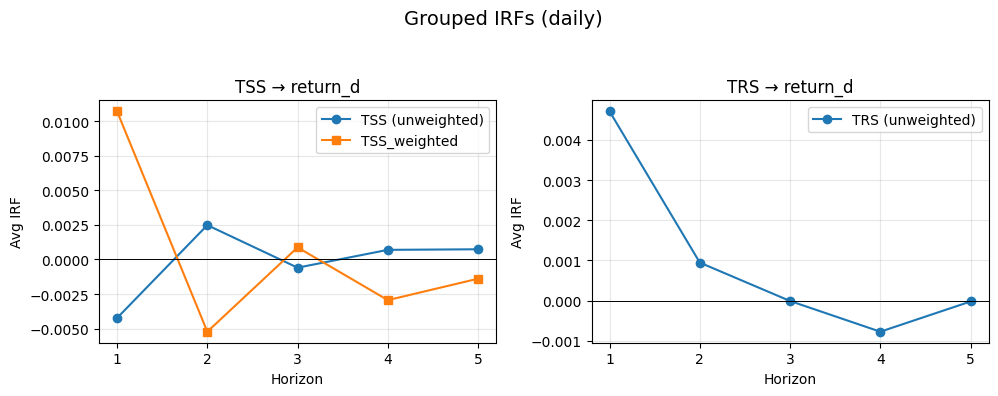

Forecast (next steps):


TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f    TSS_av   TSS_llm  \
h+1  0.711984  0.630202   0.640832     0.704351 -0.431184  0.055126   
h+2  0.756555  0.587419   0.569371     0.663510  0.226839  0.086693   
h+3  0.742362  0.616206   0.539040     0.664445  0.013104  0.133475   
h+4  0.734018  0.617889   0.558095     0.689274 -0.086388  0.066200   
h+5  0.743188  0.623326   0.552375     0.689420  0.047930  0.104097   

     TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_d  
h+1   0.127461     0.064198          0.042912 -0.002098  
h+2   0.122125     0.109901          0.074525 -0.002584  
h+3   0.115951     0.120227          0.112451 -0.002170  
h+4   0.066792     0.074454          0.057065  0.000138  
h+5   0.087834     0.106844          0.087633  0.000481


Weekly – TSS vs TRS (unweighted / weighted)


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


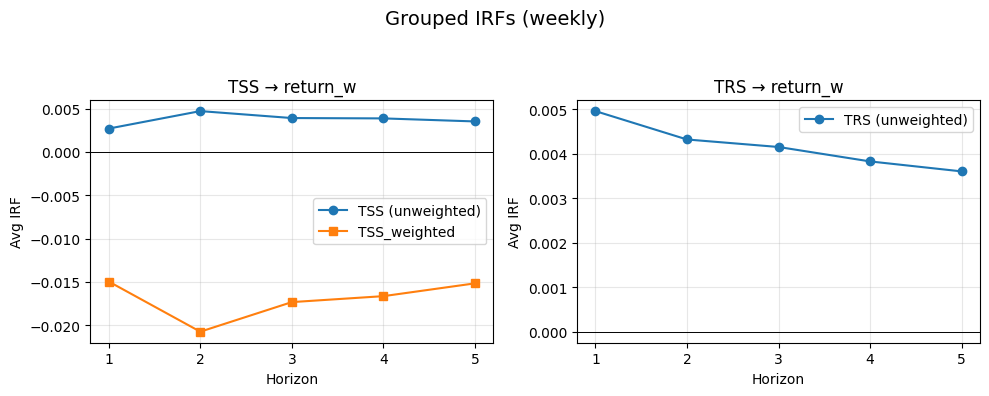

Forecast (next steps):


TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f    TSS_av   TSS_llm  \
h+1  0.731043  0.630666   0.623941     0.695135 -0.168444  0.170002   
h+2  0.738852  0.621355   0.588686     0.685414  0.058952  0.125008   
h+3  0.731940  0.625381   0.569563     0.686914 -0.027145  0.093464   
h+4  0.734201  0.625732   0.565912     0.686988  0.011561  0.086323   
h+5  0.733159  0.626587   0.562506     0.687422 -0.002743  0.081967   

     TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_w  
h+1   0.131182     0.126729          0.147988 -0.023178  
h+2   0.102802     0.118030          0.105915 -0.020575  
h+3   0.085225     0.098945          0.080924 -0.019201  
h+4   0.080369     0.097016          0.074407 -0.017593  
h+5   0.077731     0.094505          0.071082 -0.016259

In [77]:
print("Daily – TSS vs TRS (unweighted / weighted)")
plot_grouped_irfs(df, frequency='daily', prefixes=['TSS','TRS'], forecast_steps=5)

print("\nWeekly – TSS vs TRS (unweighted / weighted)")
plot_grouped_irfs(df, frequency='weekly', prefixes=['TSS','TRS'], forecast_steps=5)


In [78]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_var_grid(
    df,
    frequency='daily',
    var_order: list[str] | None = None,
    maxlags: int = 5,
    forecast_steps: int = 5,
    ci: float = 0.95
):
    """
    Fits a VAR on either daily or weekly data, then plots IRFs en una grilla 1×N,
    solo cada TSS_* → return, pero con bandas de confianza asintóticas.
    """
    # 1) pick time & return
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # 2) lista de TSS_*
    tss_cols = [c for c in df.columns if c.startswith('TSS_')]

    # 3) orden interno
    if var_order is None:
        var_order = tss_cols + [ret]
    else:
        missing = [c for c in var_order if c not in df.columns]
        if missing:
            raise KeyError(f"Columnas no encontradas: {missing}")

    # 4) arma DF para VAR
    df_var = df[[tcol] + var_order].dropna().set_index(tcol)

    # 5) estacionariza series no-estacionarias
    def make_stationary(x):
        y = x.copy()
        for col in x:
            pval = adfuller(x[col])[1]
            if pval > 0.05:
                y[col] = x[col].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 6) estima VAR
    m   = VAR(df_s)
    lag = max(int(m.select_order(maxlags).aic), 1)
    res = m.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 7) IRF + stderr
    irf    = res.irf(forecast_steps)
    irf_mat= irf.irfs            # (h+1, nvar, nvar)
    se_mat = irf.stderr          # (h+1, nvar, nvar)
    alpha  = 1 - ci
    z      = abs(np.round(scipy.stats.norm.ppf(alpha/2),2))  # 1.96 for 95%
    h      = forecast_steps
    x      = np.arange(1, h+1)

    # 8) plot 1×nimp
    impulse_vars = [v for v in var_order if v != ret]
    nimp = len(impulse_vars)
    fig, axes = plt.subplots(1, nimp, figsize=(4*nimp,3.5), squeeze=False)

    for i, var in enumerate(impulse_vars):
        idx_imp = var_order.index(var)
        idx_ret = var_order.index(ret)

        mean  = irf_mat[1:, idx_ret, idx_imp]
        stderr= se_mat[1:, idx_ret, idx_imp]
        lower = mean - z*stderr
        upper = mean + z*stderr

        ax = axes[0,i]
        # bandas punteadas
        ax.plot(x, lower, 'k--', lw=1)
        ax.plot(x, upper, 'k--', lw=1)
        # línea central
        ax.plot(x, mean, marker='o', lw=1.5)
        ax.axhline(0, color='k', lw=0.7)

        ax.set_title(f"{var} → {ret}")
        ax.set_xlabel("Horizon")
        if i==0:
            ax.set_ylabel("IRF")
        ax.set_xticks(x)
        ax.grid(alpha=0.3)

    fig.suptitle(f"Impulse Responses ({frequency})",fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    # 9) forecast (opcional)
    fc = res.forecast(df_s.values[-lag:], steps=h)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,h+1)])
    print("Forecast (next steps):")
    display(fc_df)


Daily – TSS vs TRS (unweighted / weighted)


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


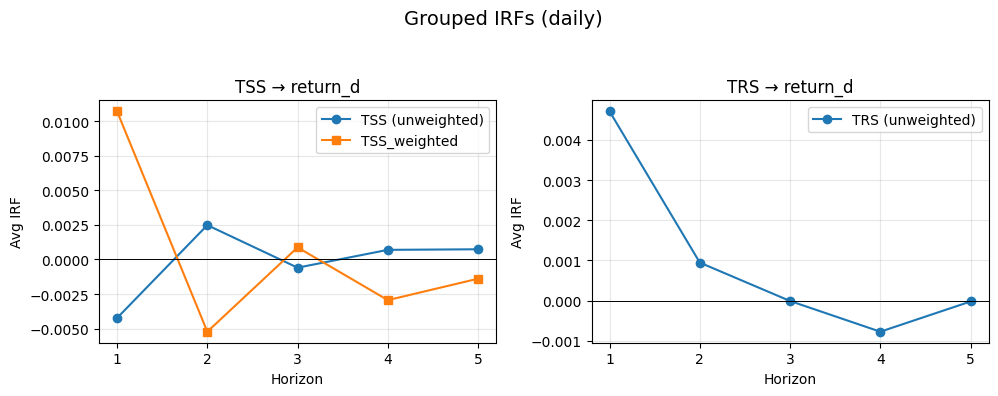

Forecast (next steps):


TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f    TSS_av   TSS_llm  \
h+1  0.711984  0.630202   0.640832     0.704351 -0.431184  0.055126   
h+2  0.756555  0.587419   0.569371     0.663510  0.226839  0.086693   
h+3  0.742362  0.616206   0.539040     0.664445  0.013104  0.133475   
h+4  0.734018  0.617889   0.558095     0.689274 -0.086388  0.066200   
h+5  0.743188  0.623326   0.552375     0.689420  0.047930  0.104097   

     TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_d  
h+1   0.127461     0.064198          0.042912 -0.002098  
h+2   0.122125     0.109901          0.074525 -0.002584  
h+3   0.115951     0.120227          0.112451 -0.002170  
h+4   0.066792     0.074454          0.057065  0.000138  
h+5   0.087834     0.106844          0.087633  0.000481


Weekly – TSS vs TRS (unweighted / weighted)


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


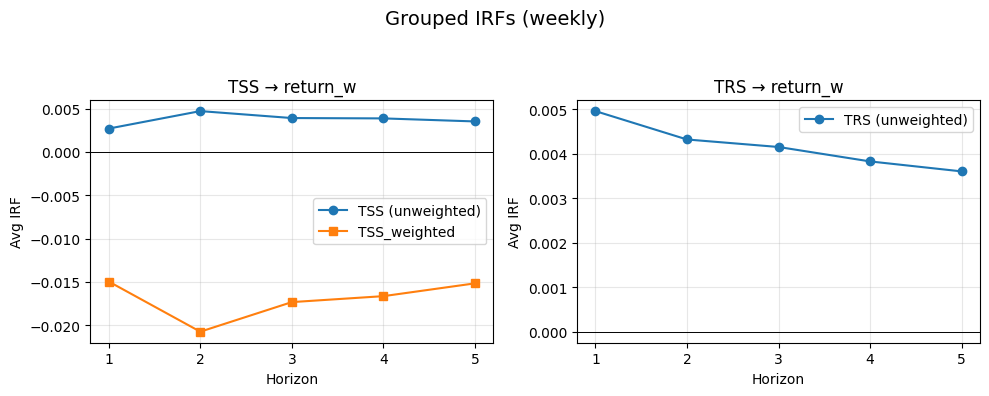

Forecast (next steps):


TRS_av   TRS_llm  TRS_llm_t  TRS_llm_t_f    TSS_av   TSS_llm  \
h+1  0.731043  0.630666   0.623941     0.695135 -0.168444  0.170002   
h+2  0.738852  0.621355   0.588686     0.685414  0.058952  0.125008   
h+3  0.731940  0.625381   0.569563     0.686914 -0.027145  0.093464   
h+4  0.734201  0.625732   0.565912     0.686988  0.011561  0.086323   
h+5  0.733159  0.626587   0.562506     0.687422 -0.002743  0.081967   

     TSS_llm_t  TSS_llm_t_f  TSS_llm_weighted  return_w  
h+1   0.131182     0.126729          0.147988 -0.023178  
h+2   0.102802     0.118030          0.105915 -0.020575  
h+3   0.085225     0.098945          0.080924 -0.019201  
h+4   0.080369     0.097016          0.074407 -0.017593  
h+5   0.077731     0.094505          0.071082 -0.016259

In [79]:
print("Daily – TSS vs TRS (unweighted / weighted)")
plot_grouped_irfs(df, frequency='daily', prefixes=['TSS','TRS'], forecast_steps=5)

print("\nWeekly – TSS vs TRS (unweighted / weighted)")
plot_grouped_irfs(df, frequency='weekly', prefixes=['TSS','TRS'], forecast_steps=5)

# **VAR** - ALL

Checkear una cosa muy clave, y es que al haber entrenado los LLMs, estos han evaluado muchos elementos con TRS no tan relevantes, asi que habria que crear una segunda graficam¡, donde se vuelva a filtrar esto, y asi ver el impacto

VAR Daily — TSS, TRS y TSS_weighted
Daily VAR — lag=1, AIC=-55.80, BIC=-53.82


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


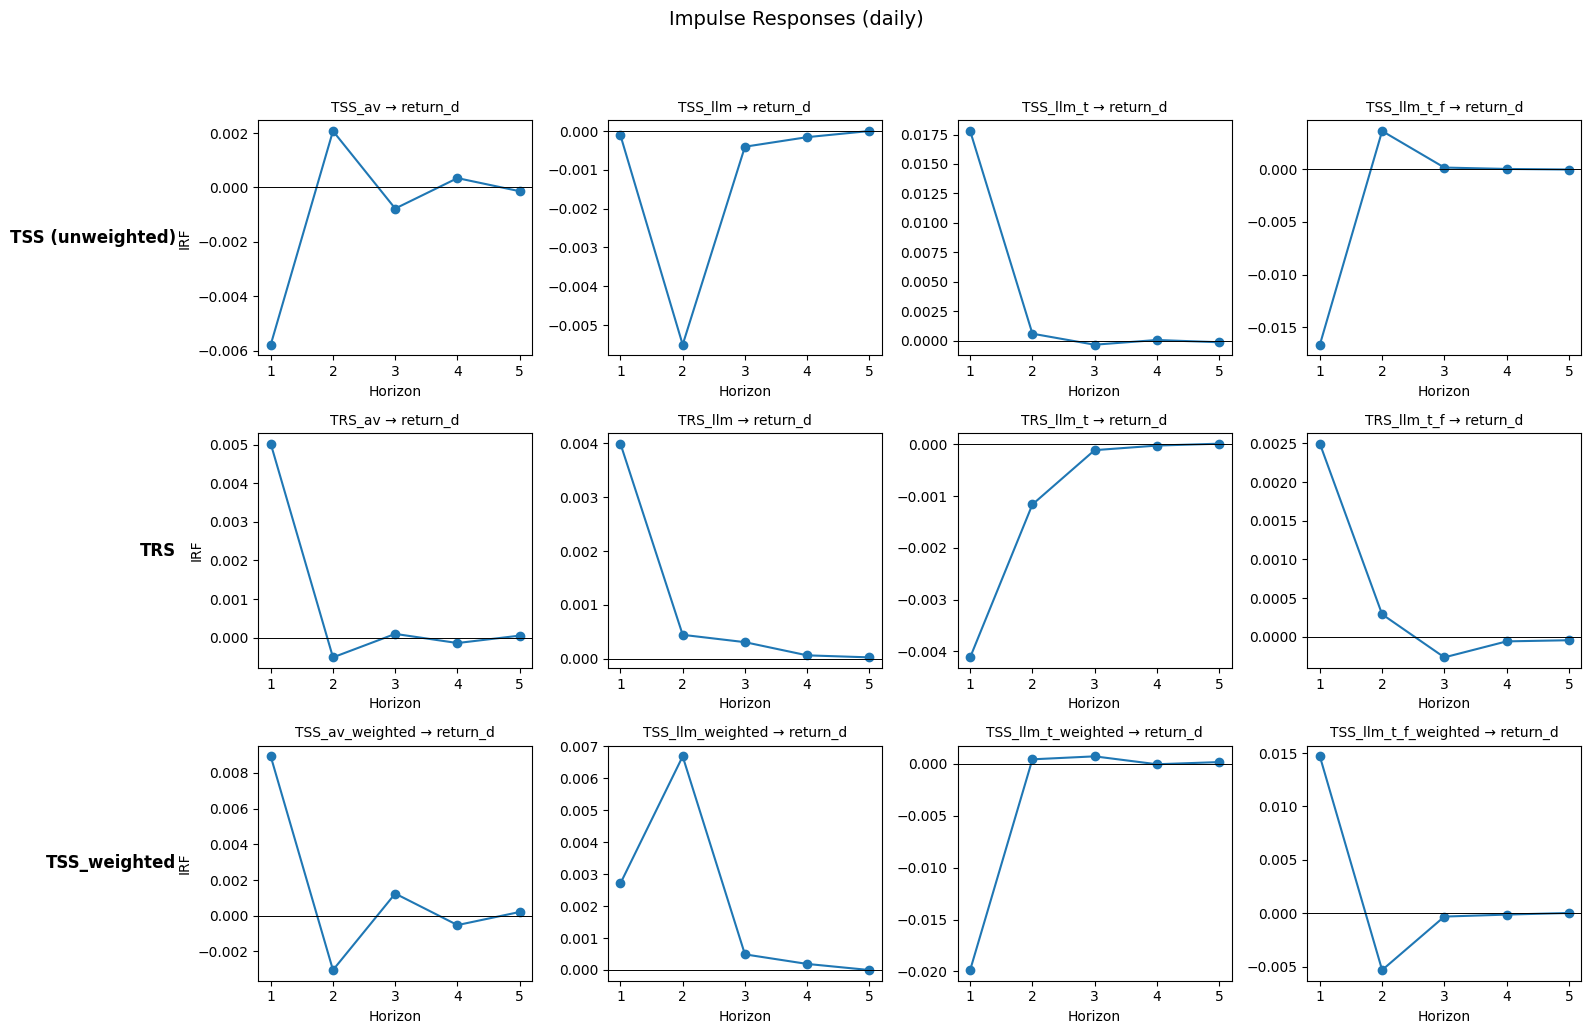

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f    TRS_av   TRS_llm  \
h+1  0.001134  0.166856   0.040278     0.186774  0.711680  0.600603   
h+2 -0.010552  0.109359   0.071885     0.142236  0.725408  0.597852   
h+3 -0.001003  0.104862   0.080402     0.122495  0.734925  0.612521   
h+4 -0.005832  0.096318   0.078775     0.110689  0.735606  0.619458   
h+5  0.000412  0.095743   0.079876     0.108028  0.735632  0.621875   

     TRS_llm_t  TRS_llm_t_f  TSS_av_weighted  TSS_llm_weighted  \
h+1   0.407672     0.701821        -0.004050          0.112648   
h+2   0.492735     0.684021        -0.000417          0.084746   
h+3   0.527377     0.685933        -0.001885          0.086257   
h+4   0.540921     0.687346        -0.003032          0.081633   
h+5   0.545176     0.686945        -0.000116          0.081733   

     TSS_llm_t_weighted  TSS_llm_t_f_weighted  return_d  
h+1            0.032062              0.141520 -0.000927  
h+2            0.057753              0.106131 -0.000184  
h+3            0.065578              0.092900 -0.000215  
h+4            0.065555              0.084415 -0.000180  
h+5            0.066592              0.082590 -0.000152


VAR Weekly — TSS, TRS y TSS_weighted
Weekly VAR — lag=1, AIC=-55.64, BIC=-53.66


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


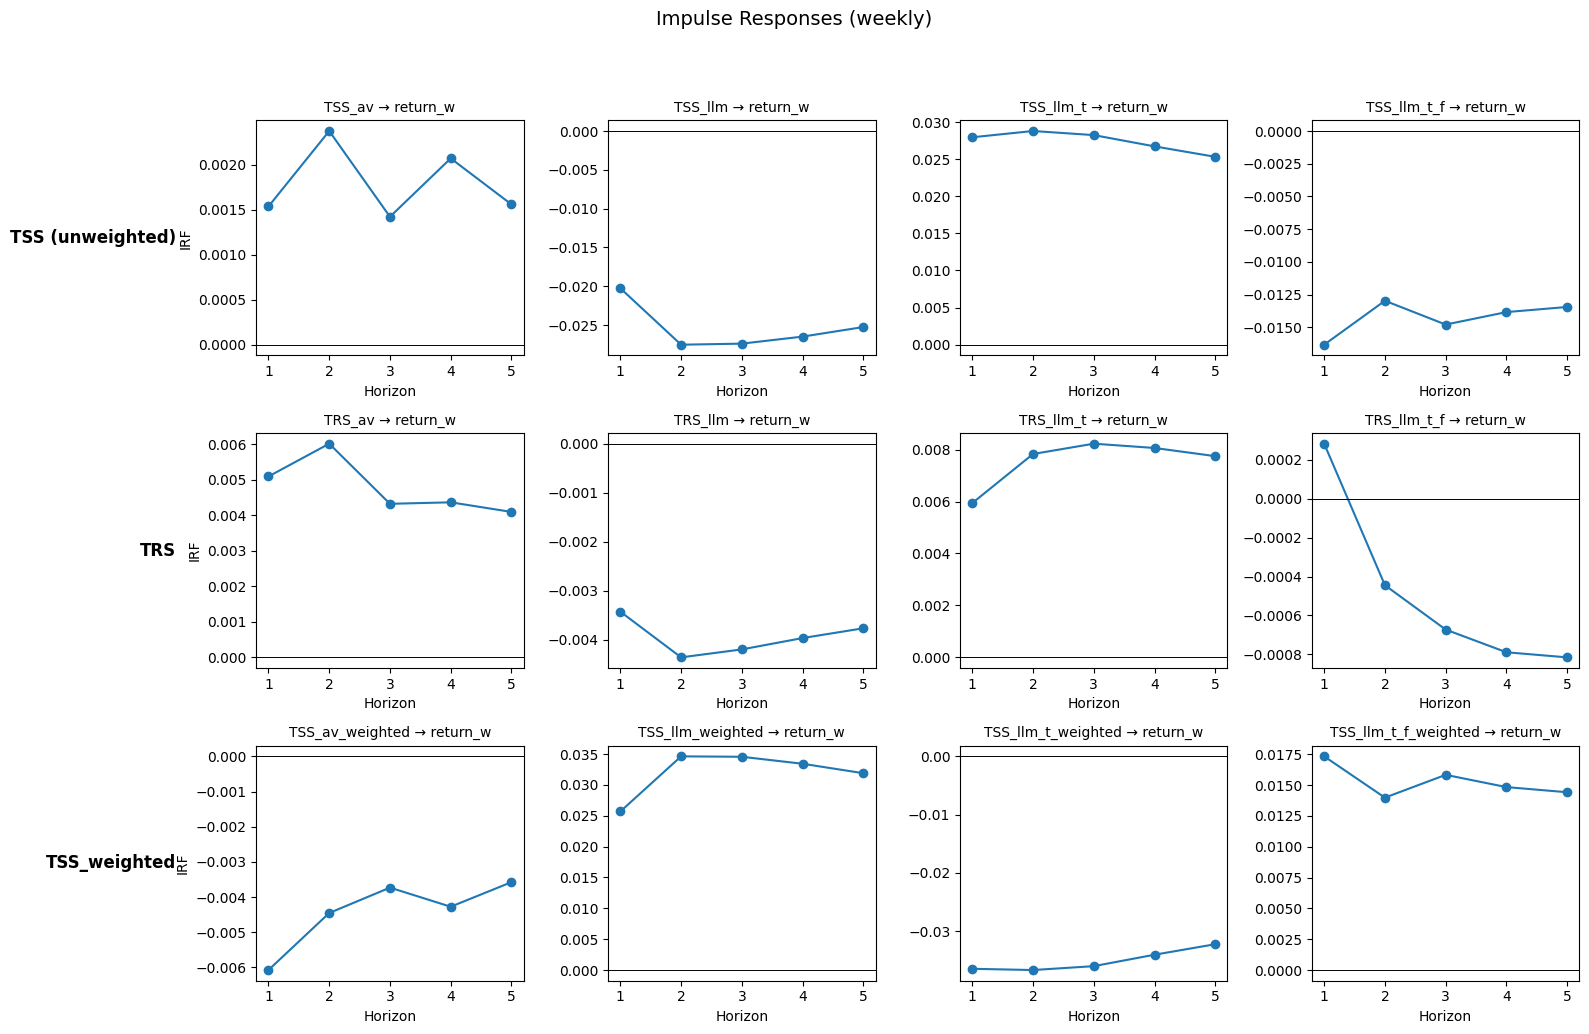

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t  TSS_llm_t_f    TRS_av   TRS_llm  \
h+1 -0.079282  0.068109  -0.036585     0.083929  0.697975  0.654015   
h+2 -0.000660 -0.004952  -0.011154     0.034070  0.701972  0.641749   
h+3 -0.014116 -0.021058  -0.004176     0.009841  0.715230  0.648118   
h+4 -0.009752 -0.025949  -0.004169     0.001090  0.716629  0.654458   
h+5 -0.004679 -0.022313   0.000450     0.002855  0.717677  0.654389   

     TRS_llm_t  TRS_llm_t_f  TSS_av_weighted  TSS_llm_weighted  \
h+1   0.453881     0.755003        -0.068965          0.031257   
h+2   0.529523     0.726542         0.004821         -0.010149   
h+3   0.558746     0.722364        -0.013876         -0.016764   
h+4   0.571173     0.722810        -0.007999         -0.018634   
h+5   0.573373     0.719965        -0.005841         -0.014963   

     TSS_llm_t_weighted  TSS_llm_t_f_weighted  return_w  
h+1           -0.011891              0.063643 -0.080122  
h+2            0.007339              0.023625 -0.077925  
h+3            0.013198              0.006633 -0.075128  
h+4            0.013958              0.000566 -0.071937  
h+5            0.017070              0.002068 -0.068833

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_prices

# ─── 1) CARGA Y PREPARACIÓN DE RETORNOS ────────────────────────────────────────

df = df_combined.copy()
df['day_date'] = pd.to_datetime(df['day_date'])

# 1.1) precios diarios → return_d
prices_d = (
    load_prices('AAPL', frequency='daily', folder='stocks')
    .reset_index().rename(columns={'date':'day_date'})
)
prices_d['day_date'] = pd.to_datetime(prices_d['day_date'])
df = df.merge(prices_d[['day_date','adjusted_close']], on='day_date', how='inner')
df = df.sort_values('day_date')
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# 1.2) retorno semanal → return_w
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_close = df.groupby('week')['adjusted_close'].last().rename('adj_w')
weekly_ret   = weekly_close.pct_change().rename('return_w')
weekly = pd.DataFrame({'adj_w':weekly_close, 'return_w':weekly_ret}) \
           .dropna().reset_index()
df = df.merge(weekly, on='week', how='inner').dropna(subset=['return_w'])


# ─── 2) CALCULAR TSS_*_WEIGHTED = TSS_* × TRS_* ───────────────────────────────
suffixes = ['av','llm','llm_t','llm_t_f']

for s in suffixes:
    tss_col = f"TSS_{s}"
    trs_col = f"TRS_{s}"
    wcol    = f"{tss_col}_weighted"
    if tss_col in df.columns and trs_col in df.columns:
        df[wcol] = df[tss_col] * df[trs_col]
    else:
        print(f"⚠️ No se crea {wcol}: falta {tss_col} o {trs_col}")


# ─── 3) FUNCIÓN PARA ESTIMAR VAR Y PLOTEAR 3×4 GRID ────────────────────────────

def run_var_grid_tss_trs(
    df: pd.DataFrame,
    frequency: str = 'daily',
    suffixes: list[str] = ['av','llm','llm_t','llm_t_f'],
    maxlags: int = 5,
    forecast_steps: int = 5
):
    # 3.1) elegir tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # 3.2) armar listas de variables
    tss_cols   = [f"TSS_{s}"            for s in suffixes if f"TSS_{s}" in df.columns]
    trs_cols   = [f"TRS_{s}"            for s in suffixes if f"TRS_{s}" in df.columns]
    tss_w_cols = [f"TSS_{s}_weighted"   for s in suffixes if f"TSS_{s}_weighted" in df.columns]

    var_order = tss_cols + trs_cols + tss_w_cols + [ret]

    # 3.3) preparar y estacionarizar
    df_var = df[[tcol] + var_order].dropna().set_index(tcol)
    def make_stationary(x):
        y = x.copy()
        for c in x.columns:
            if adfuller(x[c])[1] > 0.05:
                y[c] = x[c].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 3.4) ajustar VAR
    model = VAR(df_s)
    lag   = max(int(model.select_order(maxlags).aic), 1)
    res   = model.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 3.5) calcular IRFs
    irf_mat = res.irf(forecast_steps).irfs
    h       = forecast_steps
    x       = np.arange(1, h+1)
    ret_ix  = var_order.index(ret)

    # 3.6) plot 3 filas × 4 columnas
    n = len(suffixes)
    fig, axes = plt.subplots(3, n, figsize=(4*n, 3.5*3), squeeze=False)
    row_lists = [tss_cols, trs_cols, tss_w_cols]
    row_labels = ["TSS (unweighted)", "TRS", "TSS_weighted"]

    for row in range(3):
        vars_list = row_lists[row]
        for col in range(n):
            ax = axes[row, col]
            if col < len(vars_list):
                var = vars_list[col]
                y   = irf_mat[1:, ret_ix, var_order.index(var)]
                ax.plot(x, y, marker='o')
            else:
                ax.set_axis_off()
            ax.axhline(0, color='k', lw=0.7)
            title = vars_list[col] + " → " + ret if col < len(vars_list) else ""
            ax.set_title(title, fontsize=10)
            ax.set_xlabel("Horizon")
            if col==0:
                ax.set_ylabel("IRF")
        # etiqueta lateral
        axes[row,0].text(
            -0.3, 0.5, row_labels[row],
            va='center', ha='right',
            transform=axes[row,0].transAxes,
            fontsize=12, fontweight='bold'
        )

    fig.suptitle(f"Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.94])
    plt.show()

    # 3.7) forecast numérico opcional
    fc    = res.forecast(df_s.values[-lag:], steps=h)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,h+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── 4) INVOCACIONES ──────────────────────────────────────────────────────────

print("VAR Daily — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='daily', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)

print("\nVAR Weekly — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='weekly', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)


In [160]:
import pandas as pd
from functools import reduce


# 1) Determine your ticker
ticker = "AAPL"

# 2) Build the base directory where your LLM files live
base_dir = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker

# 3) Define file names
files = {
    "df_news_llm": f"df___{ticker}___llm.csv",
    "df_news_llm_tech": f"df___{ticker}___llm_tech.csv",
    "df_news_llm_tech_fund": f"df___{ticker}___llm_tech_fund.csv",
}

# 4) Load into variables
df_news_llm = pd.read_csv(base_dir / files["df_news_llm"])
df_news_llm_tech = pd.read_csv(base_dir / files["df_news_llm_tech"])
df_news_llm_tech_fund = pd.read_csv(base_dir / files["df_news_llm_tech"])

df_news_av = df_news_filtered.copy()

df_news_av = df_news_av.rename(columns={
    "ticker_sentiment_score": "TSS_av",
    "ticker_relevance_score": "TRS_av"
})
df_news_av = df_news_av[["idx", "time_published","day_date","week_date","TSS_av", "TRS_av"]]
df_news_av = df_news_av[df_news_av['TRS_av'] >= 0.5]

df_news_llm = df_news_llm.rename(columns={
    "ticker_sentiment_score": "TSS_llm",
    "ticker_relevance_score": "TRS_llm",
    "ticker_price_impact": "TPI_llm"
})
df_news_llm = df_news_llm[["idx", "TSS_llm", "TRS_llm", "TPI_llm"]]
df_news_llm = df_news_llm[df_news_llm['TRS_llm'] >= 0.5]

df_news_llm_tech = df_news_llm_tech.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t",
    "ticker_relevance_score": "TRS_llm_t",
    "ticker_price_impact": "TPI_llm_t"
})
df_news_llm_tech = df_news_llm_tech[["idx", "TSS_llm_t", "TRS_llm_t", "TPI_llm_t"]]
df_news_llm_tech = df_news_llm_tech[df_news_llm_tech['TRS_llm_t'] >= 0.5]

# df_news_llm_tech_fund = df_news_llm_tech_fund.rename(columns={
#     "ticker_sentiment_score": "TSS_llm_t_f",
#     "ticker_relevance_score": "TRS_llm_t_f",
#     "ticker_price_impact": "TPI_llm_t_f"
# })
# df_news_llm_tech_fund = df_news_llm_tech_fund[["idx", "TSS_llm_t_f", "TRS_llm_t_f", "TPI_llm_t_f"]]
# display(print(df_news_llm_tech_fund['TRS_llm_t_f'].count()))
# df_news_llm_tech_fund = df_news_llm_tech_fund[df_news_llm_tech_fund['TRS_llm_t_f'] >= 0.5]
# display(print(df_news_llm_tech_fund['TRS_llm_t_f'].count()))

# Lista de todos los DataFrames a unir
dfs = [
    df_news_av,
    df_news_llm,
    df_news_llm_tech
    #, df_news_llm_tech_fund
]

# Usamos reduce + pd.merge para hacer un merge sucesivo por 'idx'
df_combined = reduce(
    lambda left, right: pd.merge(left, right, on='idx', how='inner'),
    dfs
)

df_combined.columns
display(print(df_combined['idx'].count()))

1923


None

In [161]:
import pandas as pd
import numpy as np
import importlib

# importa y recarga tu módulo de utilidades
import utils
importlib.reload(utils)
from utils import load_prices

# --- función de agregados ponderados y filtrados ---
def aggregate_all_sentiments(
    df: pd.DataFrame,
    drop_columns: list = ["valuation_label"]
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # copia y limpio
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    df_clean['day_date']  = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = (
        df_clean['day_date']
        .dt.to_period('W')
        .apply(lambda r: r.start_time.date())
    )
    df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])

    # filtro de relevancia (igual que antes)
    df_filt = df_clean[df_clean['TRS_llm'] > 0.6].copy()

    # ---- aquí añadimos TODOS los weighted de TSS_* usando su TRS correspondiente ----
    bases = ['llm', 'llm_t', 'llm_t_f', 'av']
    for b in bases:
        tss_col = f"TSS_{b}"
        trs_col = f"TRS_{b}"
        wcol    = f"{tss_col}_weighted"
        if tss_col in df_filt.columns and trs_col in df_filt.columns:
            df_filt[wcol] = df_filt[tss_col] * df_filt[trs_col]

    # selecciono todas las métricas resultantes (incluye ahora los nuevos _weighted)
    selected_cols = [
        c for c in df_filt.columns
        if c.startswith(('TSS_','TRS_','TPI_'))
    ]

    # agrego por día y por semana
    daily  = (
        df_filt
        .groupby('day_date')[selected_cols]
        .mean()
        .reset_index()
    )
    weekly = (
        df_filt
        .groupby('week_date')[selected_cols]
        .mean()
        .reset_index()
    )

    return daily, weekly

# --- ejecutamos sobre tu df_combined preexistente ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# precios diarios
df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'day_date'})
df_prices_daily['day_date'] = pd.to_datetime(df_prices_daily['day_date'])

# precios semanales
df_prices_weekly = load_prices(ticker, frequency='weekly', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'week_date'})
df_prices_weekly['week_date'] = pd.to_datetime(df_prices_weekly['week_date'])

# --- merges por fecha ---
merged_daily  = pd.merge(daily_agg_comb,  df_prices_daily,  on='day_date',  how='inner')

# 1) Crea una columna "periodo_semana" en ambos dfs
weekly_agg_comb['periodo_semana']   = weekly_agg_comb['week_date'].dt.to_period('W')
df_prices_weekly['periodo_semana'] = df_prices_weekly['week_date'].dt.to_period('W')

# 2) Merge sobre el periodo
merged_weekly = pd.merge(
    weekly_agg_comb,
    df_prices_weekly,
    on='periodo_semana',
    how='inner'
)

# 3) (opcional) Si quieres volver a una fecha concreta,
#    puedes elegir el inicio ó el fin del periodo:
merged_weekly['week_start'] = merged_weekly['periodo_semana'].dt.start_time
merged_weekly['week_end']   = merged_weekly['periodo_semana'].dt.end_time

# --- creamos lags de retornos ---
for lag in (2, 3):
    merged_daily[f'return_d+{lag}']     = merged_daily['adjusted_close'].shift(-lag)/merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in (2,):
    merged_weekly[f'return_w+{lag}']     = merged_weekly['adjusted_close'].shift(-lag)/merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- preview ---
print("✅ merged_daily:")
print(merged_daily.head(3))
print("\n✅ merged_weekly:")
print(merged_weekly.head(3))


✅ merged_daily:
    day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm_t  \
0 2022-03-07 -0.219456  0.526629   -0.225     0.75     -0.2     -0.075   
1 2022-03-08 -0.281480  0.629492   -0.800     0.85     -0.7      0.100   
2 2022-03-09  0.608306  0.515127    0.750     0.90      0.6      0.500   

   TRS_llm_t  TPI_llm_t  TSS_llm_weighted  ...  3. low  4. close  \
0       0.70       -0.2           -0.1425  ...  159.04    159.30   
1       0.90       -0.3           -0.6800  ...  155.80    157.44   
2       0.95        0.7            0.6750  ...  159.41    162.95   

   adjusted_close  6. volume  7. dividend amount  8. split coefficient  \
0      156.764994   96418845                 0.0                   1.0   
1      154.934593  131148280                 0.0                   1.0   
2      160.356910   91454905                 0.0                   1.0   

   return_d+2  log_return_d+2  return_d+3  log_return_d+3  
0    0.022913        0.022654   -0.054488       -0.056029

In [162]:
# --- 1) Rename merged_daily price columns ---
merged_daily = merged_daily.rename(columns={
    "1. open":           "open",
    "2. high":           "high",
    "3. low":            "low",
    "4. close":          "close",
    "5. adjusted_close": "adjusted_close",  # if already that name you can drop
    "6. volume":         "volume",
    "7. dividend amount":"dividend"
})

# Ensure the weekly‐return column is also simply named
merged_daily = merged_daily.rename(columns={
    "return_d":    "return_d",
    "return_d+2":  "return_d+2",
    "return_d+3":  "return_d+3",
    "log_return_d+2": "log_return_d+2",
    "log_return_d+3": "log_return_d+3"
})

# If your merged_daily still has both day_date and some other date column, 
# make sure 'day_date' is the index or the canonical date field:
merged_daily['day_date'] = pd.to_datetime(merged_daily['day_date'])
merged_daily = merged_daily.set_index('day_date', drop=False)


# --- 2) Rename merged_weekly price columns & tidy up week_date ---
# First drop the duplicate week_date_y if it exists, then rename week_date_x → week_date
if 'week_date_y' in merged_weekly.columns:
    merged_weekly = merged_weekly.drop(columns=['week_date_y'])

merged_weekly = merged_weekly.rename(columns={
    'week_date_x':      'week_date',
    "1. open":          "open",
    "2. high":          "high",
    "3. low":           "low",
    "4. close":         "close",
    "5. adjusted_close":"adjusted_close",
    "6. volume":        "volume",
    "7. dividend amount":"dividend",
    # your returns lags:
    "return_w":         "return_w",
    "return_w+2":       "return_w+2",
    "log_return_w+2":   "log_return_w+2"
})

# convert week_date to datetime and set index if you like
merged_weekly['week_date'] = pd.to_datetime(merged_weekly['week_date'])
merged_weekly = merged_weekly.set_index('week_date', drop=False)


# --- 3) Verify ---
print(merged_daily.columns)
print(merged_weekly.columns)


Index(['day_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_weighted',
       'TSS_llm_t_weighted', 'TSS_av_weighted', 'open', 'high', 'low', 'close',
       'adjusted_close', 'volume', 'dividend', '8. split coefficient',
       'return_d+2', 'log_return_d+2', 'return_d+3', 'log_return_d+3'],
      dtype='object')
Index(['week_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_weighted',
       'TSS_llm_t_weighted', 'TSS_av_weighted', 'periodo_semana', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend',
       'week_start', 'week_end', 'return_w+2', 'log_return_w+2'],
      dtype='object')


⚠️ No se crea TSS_llm_t_f_weighted: falta TSS_llm_t_f o TRS_llm_t_f
VAR Daily — TSS, TRS y TSS_weighted


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Daily VAR — lag=2, AIC=-51.54, BIC=-50.88


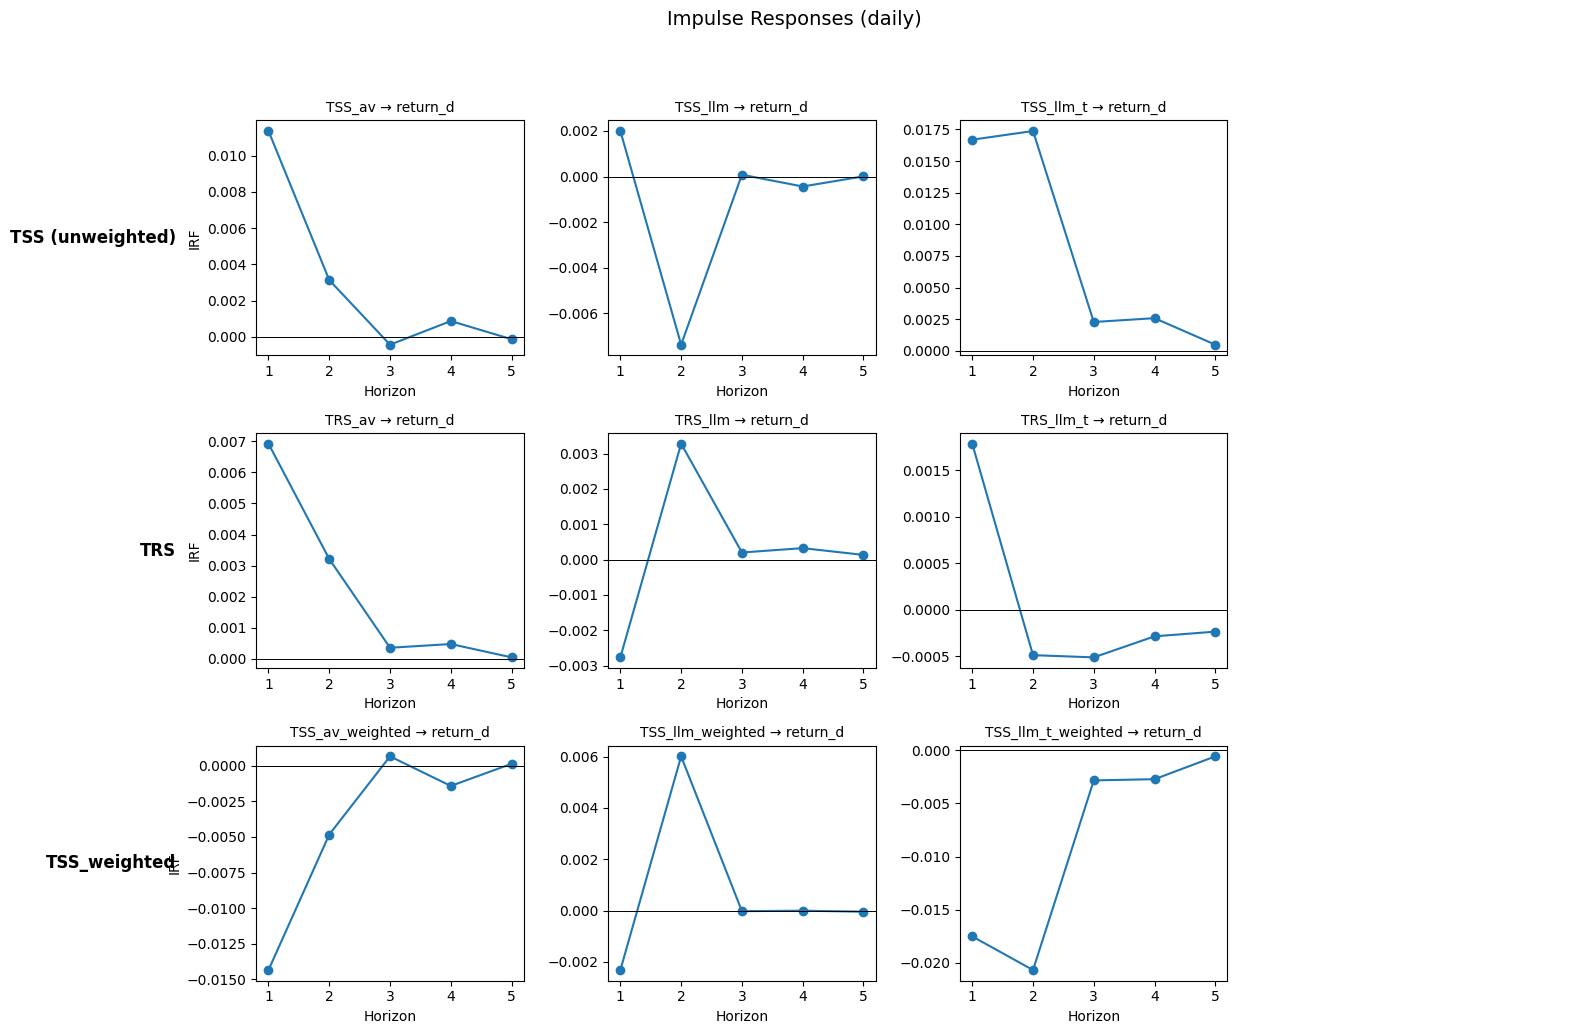

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t    TRS_av   TRS_llm  TRS_llm_t  \
h+1  0.307210  0.035276   0.219497  0.700165  0.762869   0.777132   
h+2  0.271875  0.082809   0.187610  0.717509  0.765315   0.744975   
h+3  0.292606  0.152950   0.168182  0.721624  0.761250   0.731144   
h+4  0.287105  0.168113   0.159581  0.725372  0.761983   0.722522   
h+5  0.291063  0.187183   0.159866  0.727308  0.762269   0.719521   

     TSS_av_weighted  TSS_llm_weighted  TSS_llm_t_weighted  return_d  
h+1         0.213674          0.024981            0.184031  0.001937  
h+2         0.189961          0.065860            0.153367  0.000694  
h+3         0.209362          0.123537            0.134517  0.000332  
h+4         0.207084          0.136648            0.126072  0.000395  
h+5         0.210693          0.152524            0.125635  0.000245


VAR Weekly — TSS, TRS y TSS_weighted


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Weekly VAR — lag=2, AIC=-50.77, BIC=-50.11


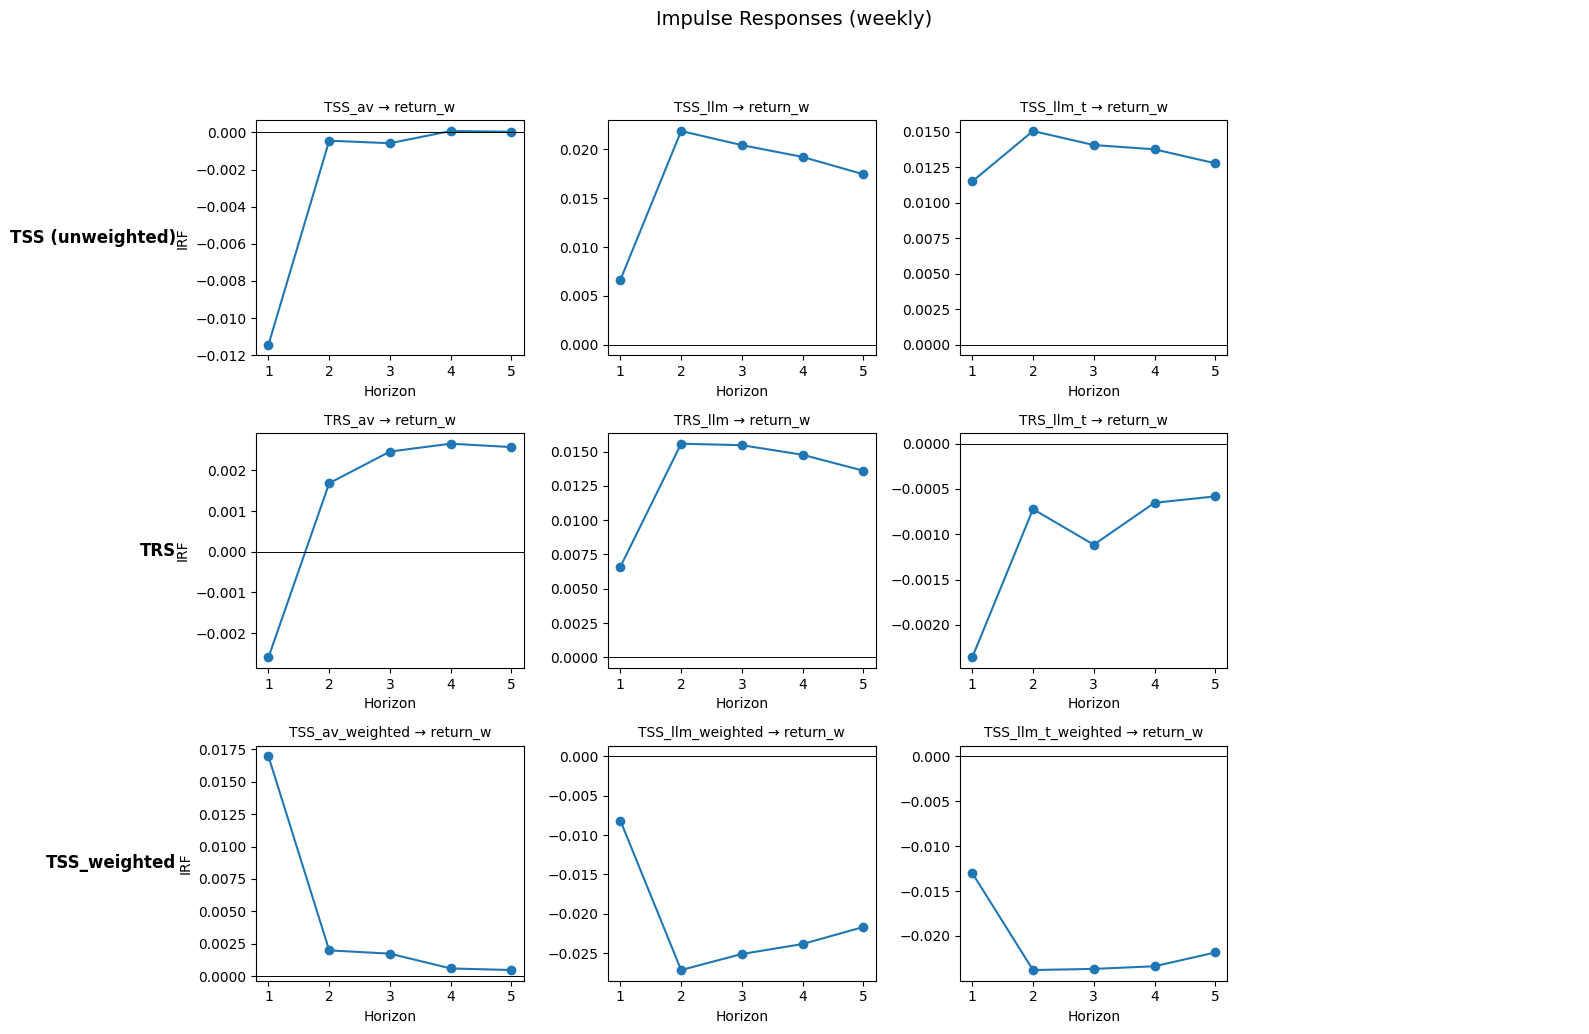

Forecast (next steps):


TSS_av   TSS_llm  TSS_llm_t    TRS_av   TRS_llm  TRS_llm_t  \
h+1  0.342894  0.088693   0.271686  0.699382  0.758414   0.784975   
h+2  0.303596  0.133329   0.239371  0.716715  0.759895   0.753709   
h+3  0.324500  0.206088   0.222606  0.724445  0.756505   0.741218   
h+4  0.318730  0.220206   0.212769  0.727529  0.757756   0.732647   
h+5  0.320262  0.236000   0.209635  0.729475  0.758558   0.729145   

     TSS_av_weighted  TSS_llm_weighted  TSS_llm_t_weighted  return_w  
h+1         0.237670          0.068310            0.224803  0.066211  
h+2         0.211776          0.106942            0.194072  0.059131  
h+3         0.231915          0.166959            0.177232  0.053834  
h+4         0.229380          0.179170            0.167870  0.049281  
h+5         0.231366          0.192363            0.164749  0.045183

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_prices

# ─── 1) CARGA Y PREPARACIÓN DE RETORNOS ────────────────────────────────────────

df = df_combined.copy()
df['day_date'] = pd.to_datetime(df['day_date'])

# 1.1) precios diarios → return_d
prices_d = (
    load_prices('AAPL', frequency='daily', folder='stocks')
    .reset_index().rename(columns={'date':'day_date'})
)
prices_d['day_date'] = pd.to_datetime(prices_d['day_date'])
df = df.merge(prices_d[['day_date','adjusted_close']], on='day_date', how='inner')
df = df.sort_values('day_date')
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# 1.2) retorno semanal → return_w
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_close = df.groupby('week')['adjusted_close'].last().rename('adj_w')
weekly_ret   = weekly_close.pct_change().rename('return_w')
weekly = pd.DataFrame({'adj_w':weekly_close, 'return_w':weekly_ret}) \
           .dropna().reset_index()
df = df.merge(weekly, on='week', how='inner').dropna(subset=['return_w'])


# ─── 2) CALCULAR TSS_*_WEIGHTED = TSS_* × TRS_* ───────────────────────────────
suffixes = ['av','llm','llm_t','llm_t_f']

for s in suffixes:
    tss_col = f"TSS_{s}"
    trs_col = f"TRS_{s}"
    wcol    = f"{tss_col}_weighted"
    if tss_col in df.columns and trs_col in df.columns:
        df[wcol] = df[tss_col] * df[trs_col]
    else:
        print(f"⚠️ No se crea {wcol}: falta {tss_col} o {trs_col}")


# ─── 3) FUNCIÓN PARA ESTIMAR VAR Y PLOTEAR 3×4 GRID ────────────────────────────

def run_var_grid_tss_trs(
    df: pd.DataFrame,
    frequency: str = 'daily',
    suffixes: list[str] = ['av','llm','llm_t','llm_t_f'],
    maxlags: int = 5,
    forecast_steps: int = 5
):
    # 3.1) elegir tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # 3.2) armar listas de variables
    tss_cols   = [f"TSS_{s}"            for s in suffixes if f"TSS_{s}" in df.columns]
    trs_cols   = [f"TRS_{s}"            for s in suffixes if f"TRS_{s}" in df.columns]
    tss_w_cols = [f"TSS_{s}_weighted"   for s in suffixes if f"TSS_{s}_weighted" in df.columns]

    var_order = tss_cols + trs_cols + tss_w_cols + [ret]

    # 3.3) preparar y estacionarizar
    df_var = df[[tcol] + var_order].dropna().set_index(tcol)
    def make_stationary(x):
        y = x.copy()
        for c in x.columns:
            if adfuller(x[c])[1] > 0.05:
                y[c] = x[c].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 3.4) ajustar VAR
    model = VAR(df_s)
    lag   = max(int(model.select_order(maxlags).aic), 1)
    res   = model.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 3.5) calcular IRFs
    irf_mat = res.irf(forecast_steps).irfs
    h       = forecast_steps
    x       = np.arange(1, h+1)
    ret_ix  = var_order.index(ret)

    # 3.6) plot 3 filas × 4 columnas
    n = len(suffixes)
    fig, axes = plt.subplots(3, n, figsize=(4*n, 3.5*3), squeeze=False)
    row_lists = [tss_cols, trs_cols, tss_w_cols]
    row_labels = ["TSS (unweighted)", "TRS", "TSS_weighted"]

    for row in range(3):
        vars_list = row_lists[row]
        for col in range(n):
            ax = axes[row, col]
            if col < len(vars_list):
                var = vars_list[col]
                y   = irf_mat[1:, ret_ix, var_order.index(var)]
                ax.plot(x, y, marker='o')
            else:
                ax.set_axis_off()
            ax.axhline(0, color='k', lw=0.7)
            title = vars_list[col] + " → " + ret if col < len(vars_list) else ""
            ax.set_title(title, fontsize=10)
            ax.set_xlabel("Horizon")
            if col==0:
                ax.set_ylabel("IRF")
        # etiqueta lateral
        axes[row,0].text(
            -0.3, 0.5, row_labels[row],
            va='center', ha='right',
            transform=axes[row,0].transAxes,
            fontsize=12, fontweight='bold'
        )

    fig.suptitle(f"Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.94])
    plt.show()

    # 3.7) forecast numérico opcional
    fc    = res.forecast(df_s.values[-lag:], steps=h)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,h+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── 4) INVOCACIONES ──────────────────────────────────────────────────────────

print("VAR Daily — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='daily', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)

print("\nVAR Weekly — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='weekly', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)
